In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scanpy as sc

In [199]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds



In [50]:
echid_status.columns=["status"]
echid_status.to_csv("echid_status.csv")

In [212]:
files = os.listdir("infercnv")
[i for i in files if "R310" in i and "on1" not in i]

['R310_pre_infercnv.csv', 'R310_on2_infercnv.csv']

R310


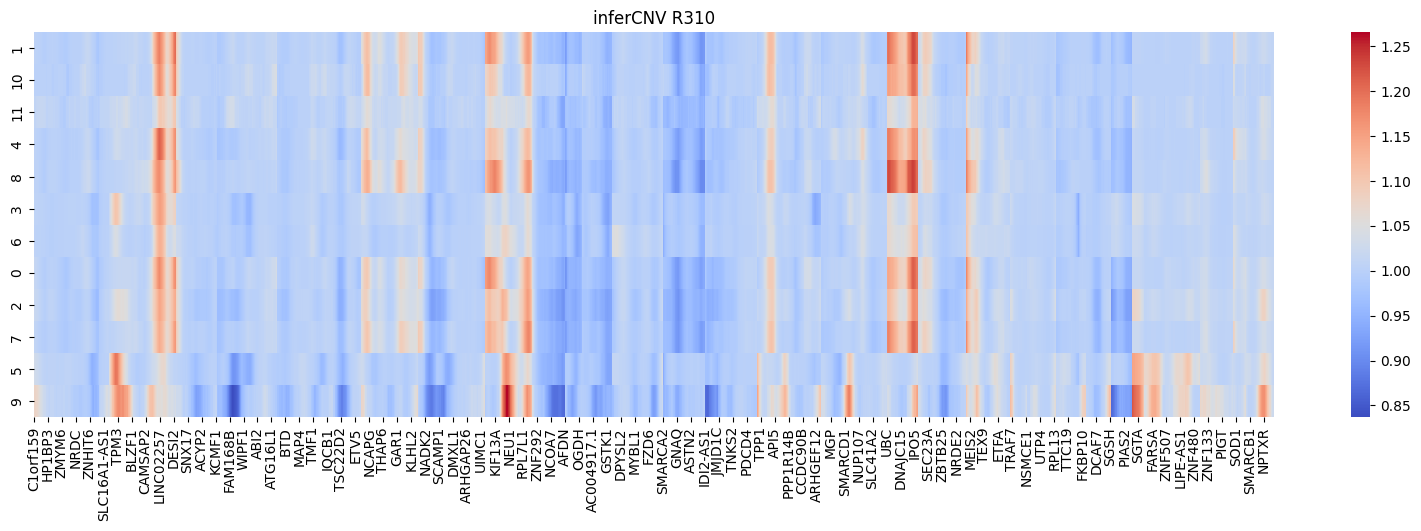

In [229]:
PATH = "params_mt_refined/"
for patient in ["R310"]:
    if "_" not in patient:
        print(patient)
        files = os.listdir("infercnv")
        read = [i for i in files if patient in i and "on1" not in i]
        infer_on = pd.read_csv("infercnv/"+read[0], index_col=0)
        infer_pre = pd.read_csv("infercnv/"+read[1], index_col=0)
    
        Xad = sc.read_h5ad("params_mt_refined/samples/"+patient+"/X.h5")
        infercnv = pd.concat((infer_pre.loc[list(np.intersect1d(infer_pre.index, infer_on.index))], 
                              infer_on.loc[list(np.intersect1d(infer_pre.index, infer_on.index))]),axis=1).T
        
        infer_inds = [i.split("-")[0] for i in infercnv.index]
        
        infercnv.index = infer_inds
        
        inds = pd.DataFrame(list(np.unique(infer_inds,return_counts=True)[0]))
        inds["counts"]=np.unique(infer_inds,return_counts=True)[1]
        
        inds = inds[inds['counts']==1]
        
        infercnv = infercnv.loc[inds[0]]
        
        X_inds = [i.split("-")[0] for i in Xad.obs_names]
        Xad.obs_names=X_inds
        
        x_inds = pd.DataFrame(list(np.unique(X_inds,return_counts=True)[0]))
        x_inds["counts"]=np.unique(X_inds,return_counts=True)[1]
        x_inds = x_inds[x_inds['counts']==1]
        
        tmp_X = Xad.obs.loc[x_inds[0]]
        
        clusters = pd.DataFrame(tmp_X["leiden"])
        clusters.index = tmp_X.index
        
        infercnv = infercnv.loc[np.intersect1d(x_inds[0],infercnv.index)]
        clusters = clusters.loc[np.intersect1d(x_inds[0],infercnv.index)]
        
        infercnv["clusters"]=clusters["leiden"]
        
        infer_heatmap=pd.DataFrame()
        for i in np.unique(infercnv["clusters"]):
            infer_heatmap[i]=np.mean(np.asarray(infercnv[infercnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
        infer_heatmap.index=infercnv.columns[:-1]
        
        clust_order = []
        obs = Xad.obs
        for i in np.unique(obs["eta_clones"]):
            clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))
        
        eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv",index_col=0).T
        intersect = np.intersect1d(infer_heatmap.index, eta.columns)
        ordered = [i for i in ordered_genes if i in intersect]
    
        eta = eta.loc[clust_order][ordered]
        infer_heatmap = infer_heatmap[clust_order].loc[ordered]
    
        plt.figure(figsize=(20,5))
        sns.heatmap(infer_heatmap.T, cmap='coolwarm')
        plt.title("inferCNV "+patient)
        #plt.savefig("FIGURES/inferCNV_r319.pdf",dpi=300)
        #eta_smoothed = scipy.ndimage.gaussian_filter1d(eta, sigma=6, axis=1, radius=8)
        
        #plt.figure(figsize=(20,5))
        #sns.heatmap(pd.DataFrame(eta_smoothed, index=clust_order), cmap='coolwarm')
        #plt.title("Eta "+patient)

In [ ]:
draw_lines, chr_list, genes = eta_no_bin(infer_heatmap)
plot = infer_heatmap.loc[genes]

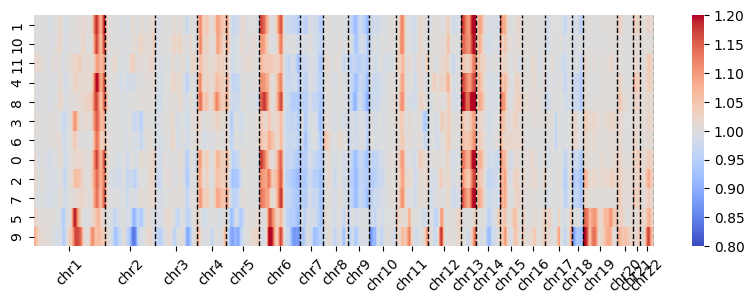

In [239]:
plt.figure(figsize=(10,3))
sns.heatmap(plot.T, cmap='coolwarm', vmin=0.8, vmax=1.2)

ticklines = []
for i in range(len(draw_lines)):
    plt.axvline(x=draw_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(draw_lines[i]-.5*draw_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)
plt.xlabel(None)
plt.savefig("InferCNV_chr_heatmap.pdf", dpi=300)

In [249]:
Xad = sc.read_h5ad("params_mt_refined/samples/"+patient+"/X.h5")

In [250]:
tmp = sc.read_h5ad("N_ribas310_clones.h5")

In [251]:
tp = pd.DataFrame(np.unique([i.split('-')[0]+"-"+i.split('-')[1] for i in tmp.obs_names], return_counts=True)).T
dups = tp[tp[1]>1][0]

In [252]:
tmp.obs_names = [i.split('-')[0]+"-"+i.split('-')[1] for i in tmp.obs_names]

In [253]:
inds = []
for i in range(len(tmp.obs_names)):
    if tmp.obs_names[i] not in list(dups):
        inds.append(i)

In [254]:
tmp = tmp[inds,:]

In [255]:
ints = np.intersect1d(tmp.obs_names, Xad.obs_names)
tmp = tmp[ints]
Xad = Xad[ints]

In [256]:
Xad.obs["infercnv_clones"]=pd.Categorical(tmp.obs["inferCNV_clones"])

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_59539/276861928.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Xad.obs["infercnv_clones"]=pd.Categorical(tmp.obs["inferCNV_clones"])


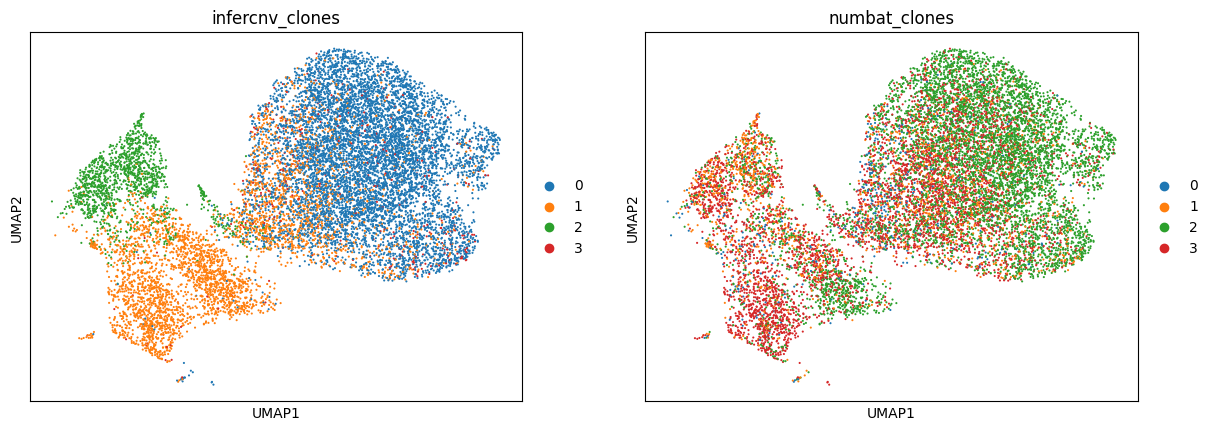

In [257]:
sc.pl.umap(Xad, color=["infercnv_clones","numbat_clones"])#,save="FIGURES/infer_numbat_umaps.pdf")
#plt.savefig("FIGURES/infer_numbat_umaps.pdf",dpi=300)

In [183]:
obs = Xad.obs
for i in np.unique(obs["leiden"]):
    subs = obs.loc[obs[obs["leiden"]==i].index]["infercnv_clones"]
    tp = pd.DataFrame(np.unique(subs, return_counts=True)).T.sort_values(by=1, ascending=False)
    print(i, tp.iloc[0][0])

0 0
1 0
10 0
11 1
2 0
3 1
4 0
5 2
6 1
7 0
8 0
9 2


In [263]:
numbat_bulk = pd.read_csv("R310_bulk_clones_final.tsv", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]
gene_cnv = (numbat_bulk
            .groupby(['sample', 'gene'], as_index=False)
            .agg(median_phi_mle=('phi_mle', 'median')))
gene_cnv['est_cn'] = gene_cnv['median_phi_mle']
clone_by_gene = gene_cnv.pivot(index='sample', columns='gene', values='est_cn')
clone_by_gene.fillna(1.0, inplace=True)
clone_by_gene.loc[1] = [1.0] * len(clone_by_gene.columns)
clone_by_gene.index.names = ['clone_opt']
numbat_clones = pd.read_csv("R310_clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
overlapping_barcodes = set(list(Xad.obs_names)).intersection(set(list(numbat_clones.index)))
Xad = Xad[Xad.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(Xad.obs_names)
nb_clones = numbat_clones[['cell', 'clone_opt']]
nb_clones = nb_clones.dropna() #this is a debug line. there shouldn't be nans if everything is correct
print(set(nb_clones['clone_opt']) - set(clone_by_gene.index)) #this is a debug line. should print empty set
nb_cnv = nb_clones.join(clone_by_gene, on='clone_opt').drop(columns=['cell', 'clone_opt']) # this is gene by cell

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_59539/3930167951.py:1: DtypeWarning: Columns (28,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("R310_bulk_clones_final.tsv", sep='\t', compression='gzip')


set()


In [265]:
nb_cnv["clusters"] = Xad.obs["leiden"]

In [267]:
draw_lines, chr_list, genes = eta_no_bin(infer_heatmap)
plot = infer_heatmap.loc[genes]

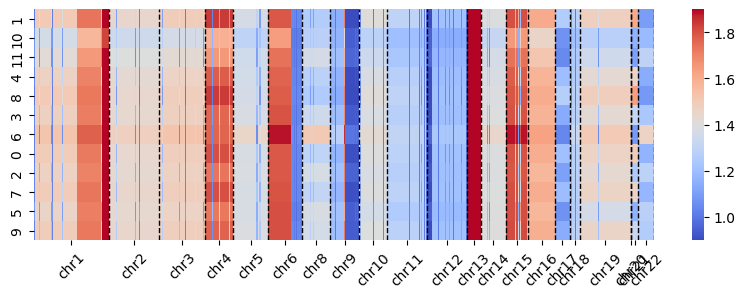

In [278]:
plt.figure(figsize=(10,3))
sns.heatmap(plot.T, cmap='coolwarm', vmin=.9, vmax=1.9)

ticklines = []
for i in range(len(draw_lines)):
    plt.axvline(x=draw_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(draw_lines[i]-.5*draw_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)
plt.xlabel(None)
plt.savefig("Numbat_chr_heatmap.pdf", dpi=300)

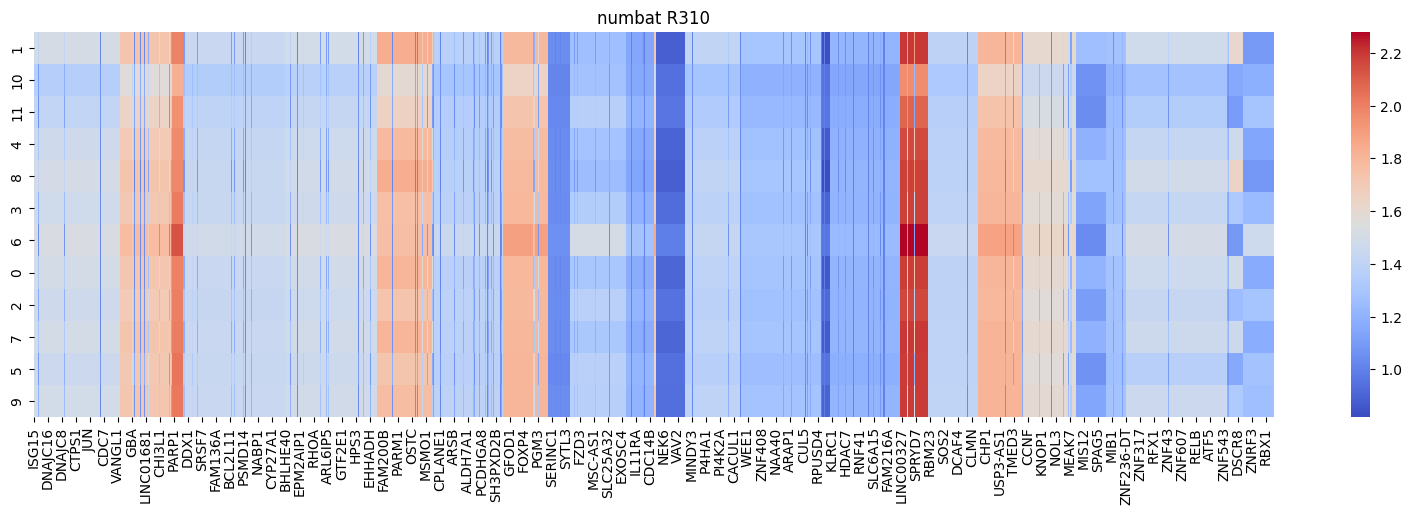

In [197]:
infer_heatmap=pd.DataFrame()
for i in np.unique(nb_cnv["clusters"]):
    infer_heatmap[i]=np.mean(np.asarray(nb_cnv[nb_cnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
infer_heatmap.index=nb_cnv.columns[:-1]

clust_order = []
obs = Xad.obs
for i in np.unique(obs["eta_clones"]):
    clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))

eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv",index_col=0).T
intersect = np.intersect1d(infer_heatmap.index, eta.columns)
ordered = [i for i in ordered_genes if i in intersect]

eta = eta.loc[clust_order][ordered]
infer_heatmap = infer_heatmap[clust_order].loc[ordered]

plt.figure(figsize=(20,5))
sns.heatmap(infer_heatmap.T, cmap='coolwarm')
plt.title("numbat "+patient)
#plt.savefig("FIGURES1/numbat_R310.pdf",dpi=300)

Text(0.5, 1.0, 'numbat R310')

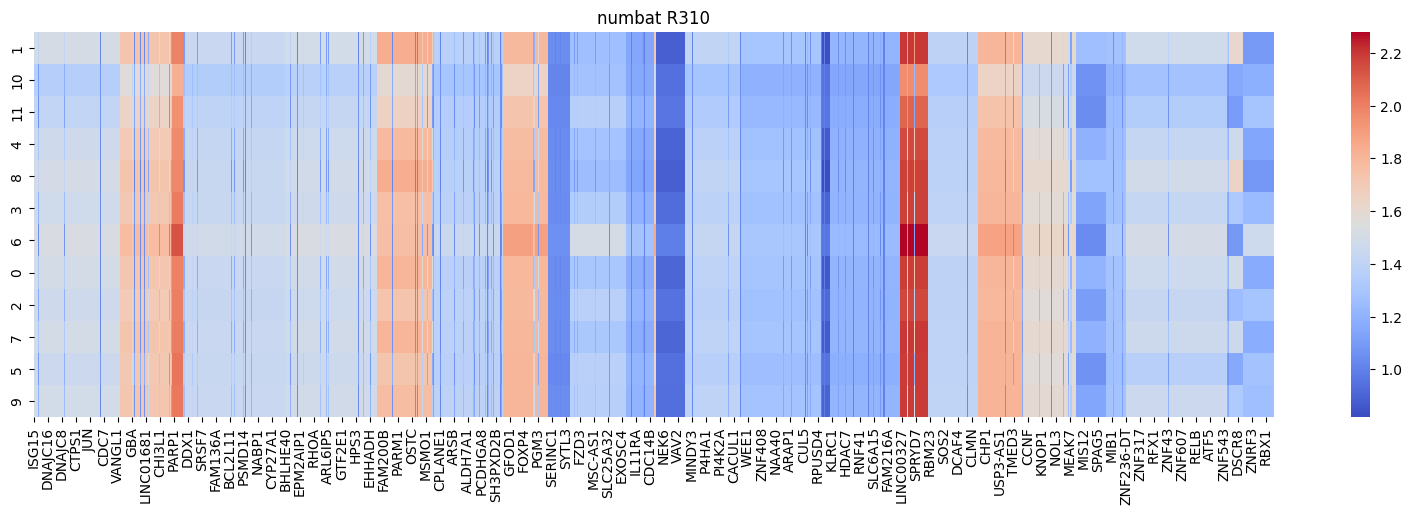

In [266]:
infer_heatmap=pd.DataFrame()
for i in np.unique(nb_cnv["clusters"]):
    infer_heatmap[i]=np.mean(np.asarray(nb_cnv[nb_cnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
infer_heatmap.index=nb_cnv.columns[:-1]

clust_order = []
obs = Xad.obs
for i in np.unique(obs["eta_clones"]):
    clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))

eta = pd.read_csv("params_mt_refined/samples/"+patient+"/eta.csv",index_col=0).T
intersect = np.intersect1d(infer_heatmap.index, eta.columns)
ordered = [i for i in ordered_genes if i in intersect]

eta = eta.loc[clust_order][ordered]
infer_heatmap = infer_heatmap[clust_order].loc[ordered]

plt.figure(figsize=(20,5))
sns.heatmap(infer_heatmap.T, cmap='coolwarm')
plt.title("numbat "+patient)

In [198]:
obs = Xad.obs
for i in np.unique(obs["leiden"]):
    subs = obs.loc[obs[obs["leiden"]==i].index]["numbat_clones"]
    tp = pd.DataFrame(np.unique(subs, return_counts=True)).T.sort_values(by=1, ascending=False)
    print(i, tp.iloc[0][0])

0 2
1 2
10 1
11 3
2 3
3 2
4 2
5 3
6 3
7 2
8 2
9 2


In [835]:
neut_vals.to_csv("R310_bin_neutrals.csv")

In [1051]:
from hmmlearn import hmm
pal = {"del":"blue","neut":"grey","amp":"red"}

import pickle
with open('bands_dict.pkl', 'rb') as f:
    bands = pickle.load(f)
    
def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(i)
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list


def get_states(vals, vals_filtered, gene_names, n_components=5, neutral=2, transition=1, startprob=1, p_thresh=1e-5):
    '''
    implements a gaussian hmm to call copy number states smoothing along the genome
    vals: ordered copy number values (from bin_by_bands function)
    n_components: number of components to use for the hmm. We default to 5 for better sensitivity.
    neutral: the number to use for neutral. For Echidna, this is always 2. 
    transition: specifies the transmat_prior in the GaussianHMM function
    startprob: specifies the startprob_prior in the GaussianHMM function
    '''
    scores = list()
    models = list()
    
    for idx in range(10):  # ten different random starting states
        # define our hidden Markov model
        model = hmm.GaussianHMM(n_components=n_components, random_state=idx, n_iter=200)
        model.fit(vals[:, None])
        models.append(model)
        scores.append(model.score(vals[:, None]))
        print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {scores[-1]}')
    
    # get the best model
    model = models[np.argmax(scores)]
    print(f'The best model had a score of {max(scores)} and '
          f'{model.n_components} components')
    
    # use the Viterbi algorithm to predict the most likely sequence of states given the model
    states = model.predict(vals[:, None])

    gmm = GaussianMixture(n_components=5)

    # Fit the model to the data
    gmm.fit(np.asarray([vals_filtered]).T)


    # Predict the cluster for each data point
    labels = gmm.predict(np.asarray([vals]).T)
    
    neut_component = scipy.stats.mode(labels)[0]
    print(np.unique(labels, return_counts=True))
    gmm_val = pd.DataFrame({"components":labels,"vals":vals})
    gmm_mean = np.mean(gmm_val[gmm_val["components"]==neut_component]["vals"])
    gmm_std = np.std(gmm_val[gmm_val["components"]==neut_component]["vals"])

    #figure out which states are neutral
    val_states = pd.DataFrame([vals, states]).T
    neut_states = []
    #print(gmm_mean+1.96*gmm_std, gmm_mean-1.96*gmm_std)
    for i in range(n_components):
        s1 = val_states[val_states[1]==i][0]
        #print(i, np.mean(s1))
        #print(scipy.stats.mode(s1)[0]<(gmm_mean+1.96*gmm_std), scipy.stats.mode(s1)[0]>(gmm_mean-1.96*gmm_std))
        
        if (np.mean(s1)<(gmm_mean+1.96*gmm_std)) and (np.mean(s1)>(gmm_mean-1.96*gmm_std)):
            #print(i,j,p)
            #if p>1e-30 and p<1 and (i not in np.asarray(same).flatten() and j not in np.asarray(same).flatten()):
                #same.append([i,j])
            neut_states.append(i)
    #plt.hist(gmm_val[gmm_val["components"]==neut_component]["vals"])
    #for n in range(n_components):
    #    plt.hist(val_states[val_states[1]==n][0], label=n)
    #plt.legend()
    #return neut_states,states
    '''
    #figure out which states are the same state
    val_states = pd.DataFrame([vals, states]).T
    same = pd.DataFrame()
    for i in range(n_components):
        for j in range(n_components):
            s1 = val_states[val_states[1]==i][0]
            s2 = val_states[val_states[1]==j][0]
            p=scipy.stats.mannwhitneyu(s1, s2)[1]
            #print(i,j,p)
            #if p>1e-30 and p<1 and (i not in np.asarray(same).flatten() and j not in np.asarray(same).flatten()):
                #same.append([i,j])
            same[str(i)+"_"+str(j)]=[p]
    return same,states
    '''
    state_dict = pd.DataFrame()
    for i in np.unique(states):
        mean = val_states[val_states[1]==i].mean()
        state_dict[i] = mean
        
    state_dict = state_dict.T
    '''
    #at the BAND level, identify the most frequent state and make that the neutral
    gene_cnv = pd.DataFrame({"gene":gene_names,"state":states})
    gene_cnv.index = gene_cnv.gene
    
    band_cnv = pd.DataFrame()
    for band in bands.keys():
        intersect = np.intersect1d(gene_cnv.index, bands[band])
        if len(intersect)>0:
            most_freq = pd.DataFrame(np.unique(gene_cnv.loc[intersect]["state"], 
                                               return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            tmp = pd.DataFrame({"band":band, "state":most_freq}, index = [band])
            band_cnv = pd.concat((band_cnv, tmp))
    
    neut_state = pd.DataFrame(np.unique(band_cnv["state"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
    neut_state = [neut_state]
    neut_val = list(state_dict[state_dict["states"]==neut_state[0]]["vals"])
    
    state_dict = state_dict.sort_values(by='vals')
    #state_dict["dist_to_neut"] = abs(state_dict["vals"]-neut_val)
    state_dict.index=state_dict.states  
    '''
    #assign everything less than neutral as deleted and greater than as amplified
    cnvs = []
    shift = 2-gmm_mean
    for i in range(state_dict.shape[0]):
        if state_dict[1].iloc[i] in neut_states:
            cnvs.append(gmm_mean+shift)
        else:
            cnvs.append(state_dict.iloc[i][0]+shift)
    
    state_dict["CNV"]=cnvs
    print(state_dict)
    #print("neut", neut_val)
    #print(state_dict)
    #print(pd.DataFrame(np.unique(band_cnv["state"], return_counts=True)).T.sort_values(by=1, ascending=False))
    convert = {state_dict[1][i]:state_dict["CNV"][i] for i in np.unique(states)}
    cnvs = [convert[i] for i in states]
    return cnvs, gmm_mean

def plot(vals, states, title, draw_lines, chrs):
    '''
    plot the CNV states along the genome
    vals: ordered copy number values (from bin_by_bands function)
    states: CN state calls from the HMM (get_states function)
    title: title of the figure, for saving
    draw_lines: coordinates of the end of each chromosome (from bin_by_bands)
    chrs: chromosome names (from bin_by_bands)
    '''
    plt.figure(figsize=(25,5))
    bar_width = 0.8
    
    # Calculate the x positions for the bars
    x_positions = np.arange(len(vals))
    
    flipped = []
    for i in states:
        if i=="neut":
            flipped.append('grey')
        elif i=="amp":
            flipped.append('red')
        else:
            flipped.append('blue')

    for i in range(len(flipped)):
        plt.axvline(x=x_positions[i], color=flipped[i], linestyle='-', alpha=0.01, linewidth=1)
        
    plt.scatter(x_positions, vals, c=flipped,s=3)
    
    # Set the x-axis ticks and labels
    ticks = []
    for i in range(len(draw_lines)):
        if i==0:
            ticks.append(draw_lines[i]/2)
        else:
            ticks.append(draw_lines[i-1]+(draw_lines[i]-draw_lines[i-1])/2)

    plt.xticks(ticks=ticks, labels=chrs)
    
    for x in draw_lines:
        plt.axvline(x=x, color='r', linestyle='--', linewidth=1)  # Draw vertical line at each x-coordinate
        
    plt.xlabel('Bands')
    plt.ylabel('CN')
    plt.title(title)
    plt.grid(True)
    plt.savefig(title+".png",format="png")
    plt.show()

In [907]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg correction
bh_corrected_p = multipletests(same.T[0], method='bonferroni')[1]
bh_corrected_p

array([0.00000000e+00, 0.00000000e+00, 3.55262155e-05, 0.00000000e+00,
       0.00000000e+00])

In [1060]:
PATH = "params_mt_refined/"
pt_states = {}
pt_neuts = {}
for patient in os.listdir("params_mt_refined"):
    if "_" not in patient:
        print(patient)
        
        eta = pd.read_csv("params_mt_refined/"+patient+"/eta.csv", index_col=0).T
        Xad = sc.read_h5ad("params_mt_refined/"+patient+"/X.h5")
        df = Xad.to_df()
        var = pd.DataFrame(df.var())
        var_filter = var[var[0]>.015].index
        ordered = [i for i in ordered_genes if i in eta.columns]
        ordered_filtered = [i for i in ordered_genes if i in var_filter]
        eta = eta[ordered]
        eta_filtered = eta[ordered_filtered] #the filtered is for fitting the gmm to get denoised neutral estimates
        clust_order = []
        obs = Xad.obs
        for i in np.unique(obs["eta_clones"]):
            clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))
        eta_smoothed = scipy.ndimage.gaussian_filter1d(eta.loc[clust_order], sigma=10, axis=1, radius=20)
        eta_filtered_smoothed = scipy.ndimage.gaussian_filter1d(eta_filtered.loc[clust_order], sigma=10, axis=1, radius=20)
        hm = pd.DataFrame()
        eta_smoothed = pd.DataFrame(eta_smoothed, index=clust_order, columns=eta.columns)
        eta_filtered_smoothed = pd.DataFrame(eta_filtered_smoothed, index=clust_order, columns=eta_filtered.columns)
        for j in eta_smoothed.index:
            vals = np.asarray(eta_smoothed.loc[j])
            vals_filtered = np.asarray(eta_filtered_smoothed.loc[j])
            cnvs, neut_val = get_states(vals, vals_filtered, eta.columns, transition=3)
            hm[j]=[cnvs]
            pt_neuts[patient+"_"+j]=neut_val
            #break
        h = pd.DataFrame()
        for col in hm.columns:
            h[col] = [i for i in hm[col][0]]
        h.index = eta.columns
        pt_states[patient]=h
        

F16
Converged: True		Score: 23103.47009727934
Converged: True		Score: -3005.5108592693327
Converged: True		Score: 23029.877632752057
Converged: True		Score: 20961.58872885588
Converged: True		Score: 20579.662607560378
Converged: True		Score: 20578.092266239015
Converged: True		Score: 26139.92817051959
Converged: True		Score: 16322.506213089704
Converged: True		Score: 21246.718006716528
Converged: True		Score: 26139.92957230683
The best model had a score of 26139.92957230683 and 5 components
(array([0, 1, 2, 3, 4]), array([9932,  800, 5893, 4115, 4303]))
          0    1       CNV
0  0.697105  0.0  1.072783
1  2.654466  1.0  3.030144
2  1.565317  2.0  2.000000
3  3.744544  3.0  4.120222
4  1.612546  4.0  2.000000
Converged: True		Score: 23811.749701514214
Converged: True		Score: 20616.86334524932
Converged: True		Score: 14852.608208706217
Converged: True		Score: 20616.03166779248
Converged: True		Score: 18091.318565955262
Converged: True		Score: 17834.829885128987
Converged: True		Score

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Converged: True		Score: 15993.979944110573
Converged: True		Score: 3611.3706438406516
Converged: True		Score: 15993.766244928842
Converged: True		Score: 15993.755804644055
Converged: True		Score: 1031.4480835624368
Converged: True		Score: 1031.4488637186105
Converged: True		Score: 18827.317303682987
Converged: True		Score: 10304.421408463091
Converged: True		Score: 3611.6422538049624
Converged: True		Score: 3611.7134886959443
The best model had a score of 18827.317303682987 and 5 components
(array([0, 1, 2, 3, 4]), array([8803, 1630, 3820,  236, 8675]))
          0    1       CNV
0  0.800397  0.0  2.000000
1  0.611505  1.0  2.000000
2  1.255015  2.0  2.000000
3  3.514991  3.0  4.593561
4  2.002772  4.0  3.081342
Converged: True		Score: 15983.879143056494
Converged: True		Score: 17583.599218118925
Converged: True		Score: 15983.752169951935
Converged: True		Score: 16308.877639634735
Converged: True		Score: 17583.68370280915
Converged: True		Score: 362.13655224569766
Converged: True		Scor

<Axes: xlabel='genes'>

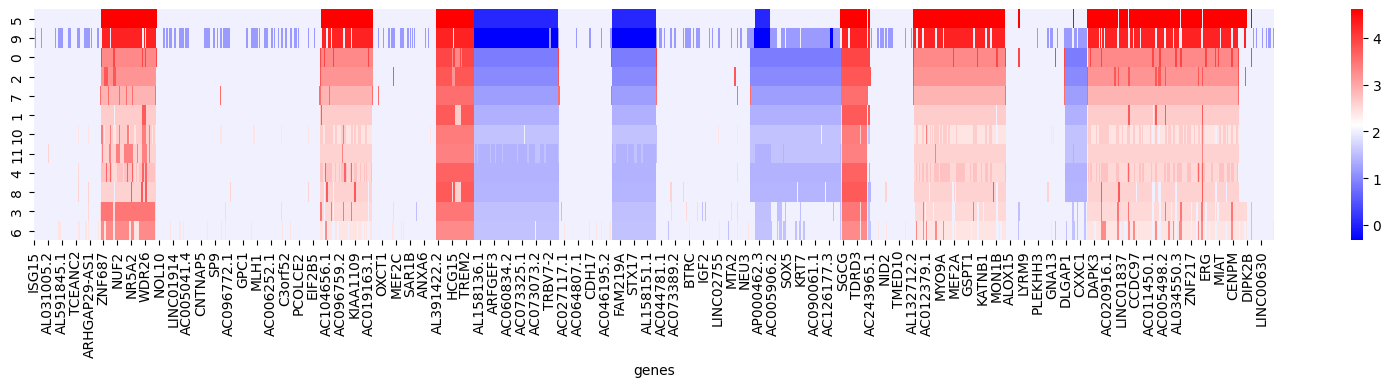

In [1042]:
plt.figure(figsize=(20,3))
sns.heatmap(h.T, cmap='bwr')

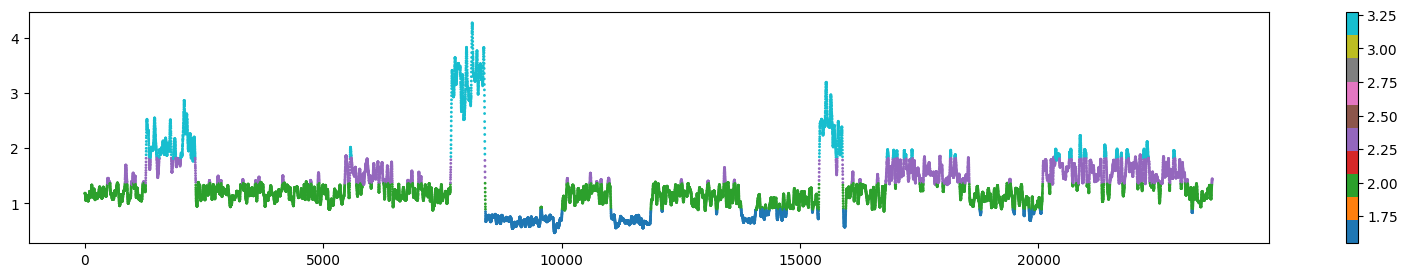

In [1039]:
plt.figure(figsize=(20,3))
plt.scatter([i for i in range(len(vals))],vals, c=cnvs,s=1,cmap='tab10')
plt.colorbar()

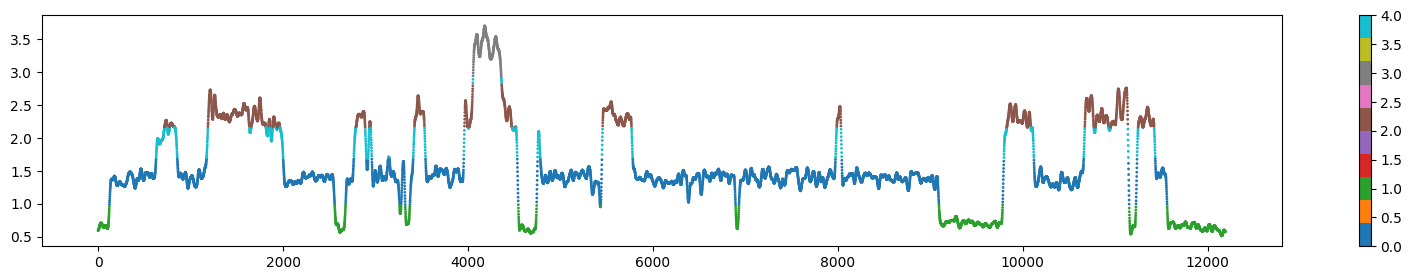

In [911]:
plt.figure(figsize=(20,3))
plt.scatter([i for i in range(len(vals))],vals, c=labels,s=1,cmap='tab10')
plt.colorbar()

In [1048]:
neuts_df = pd.DataFrame()
for key in pt_neuts.keys():
    neuts_df[key] = [pt_neuts[key]]

In [983]:
ip = pd.read_csv("var_exp_mt.csv", index_col=0).dropna()

In [1049]:
neuts_df[ip.columns].to_csv("all_patient_UNFILTERED_neutral_values.csv")

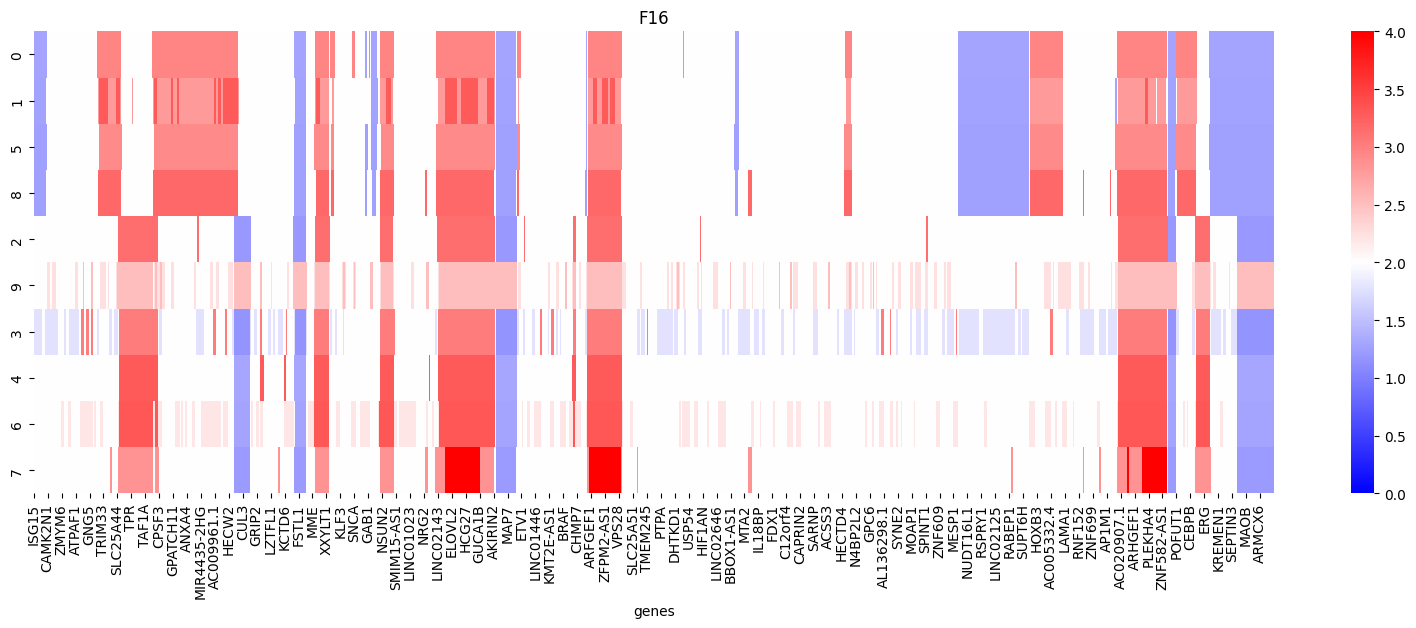

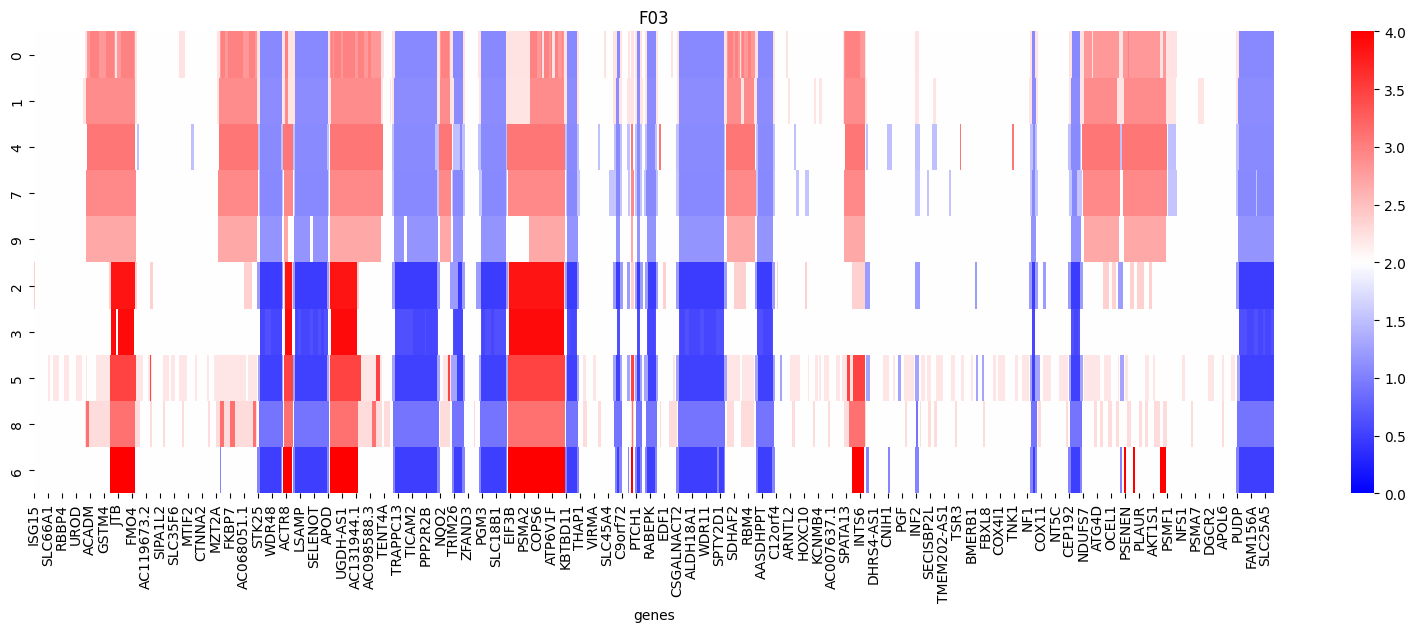

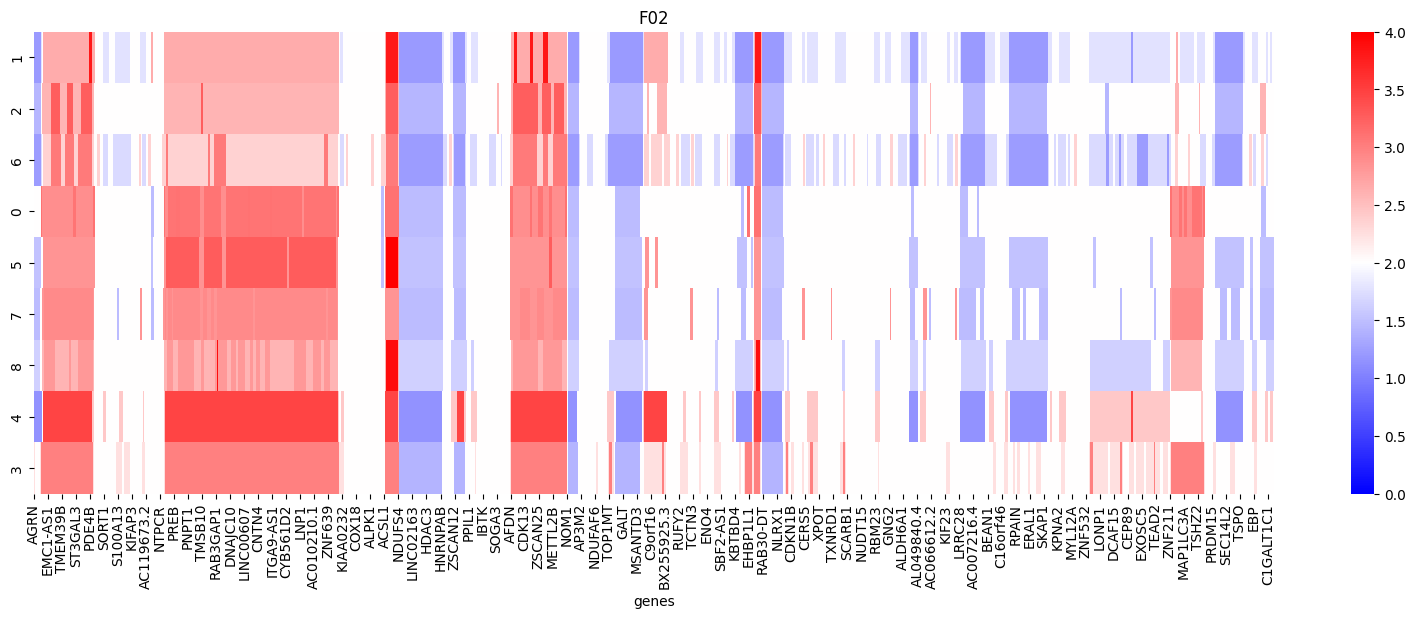

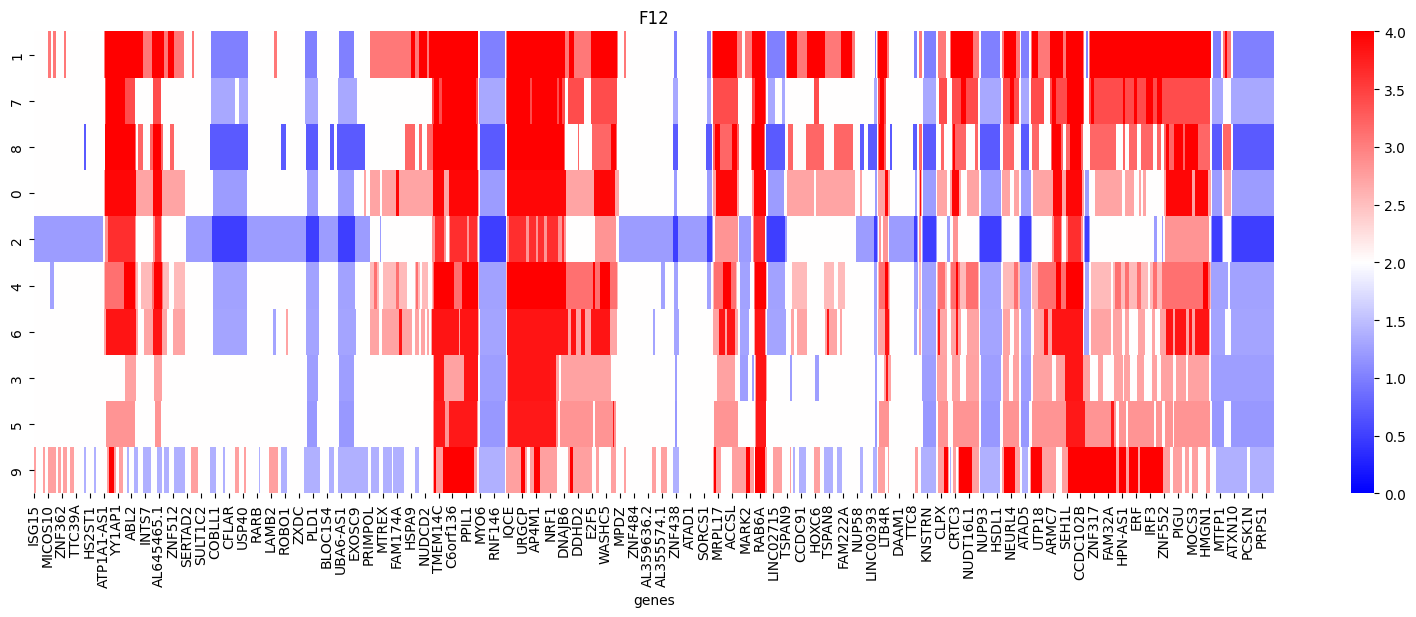

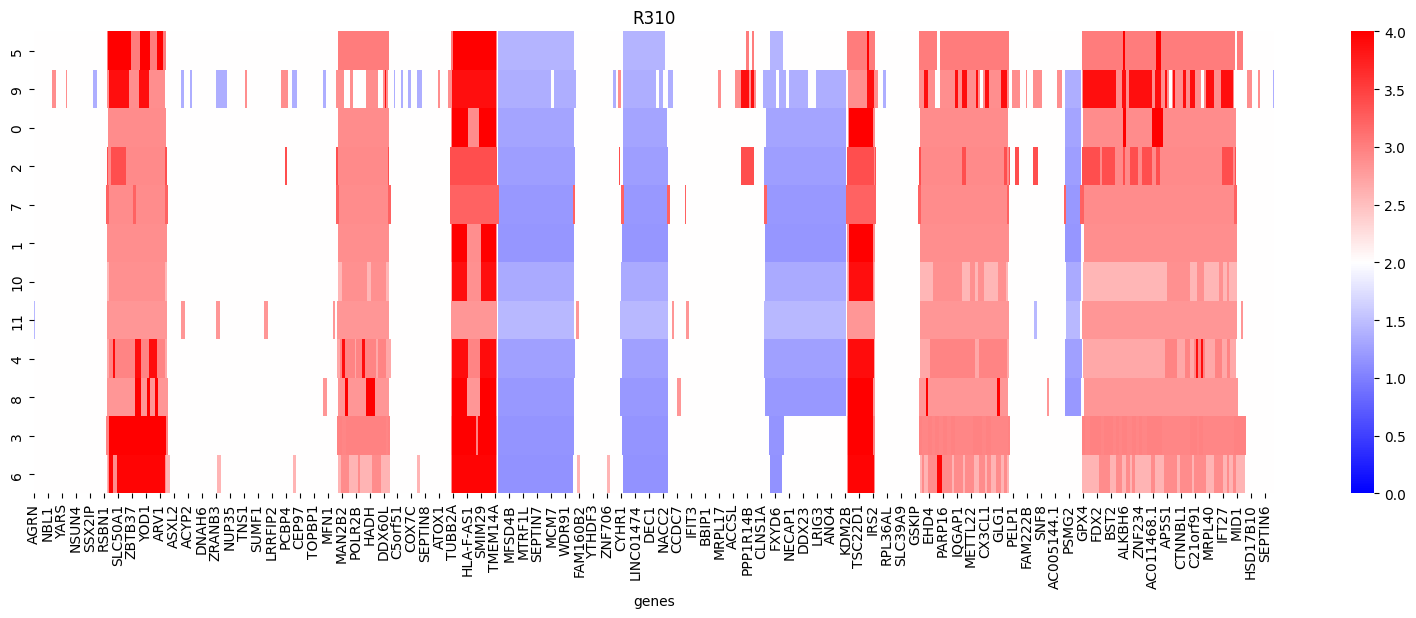

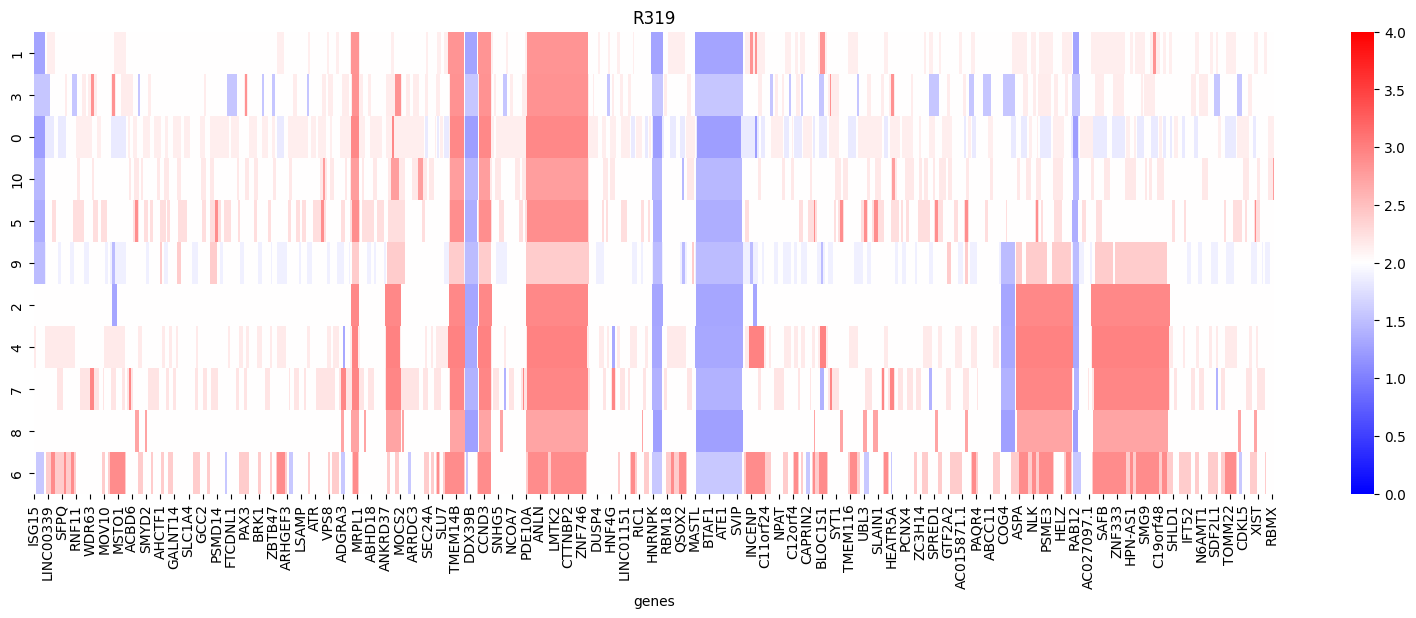

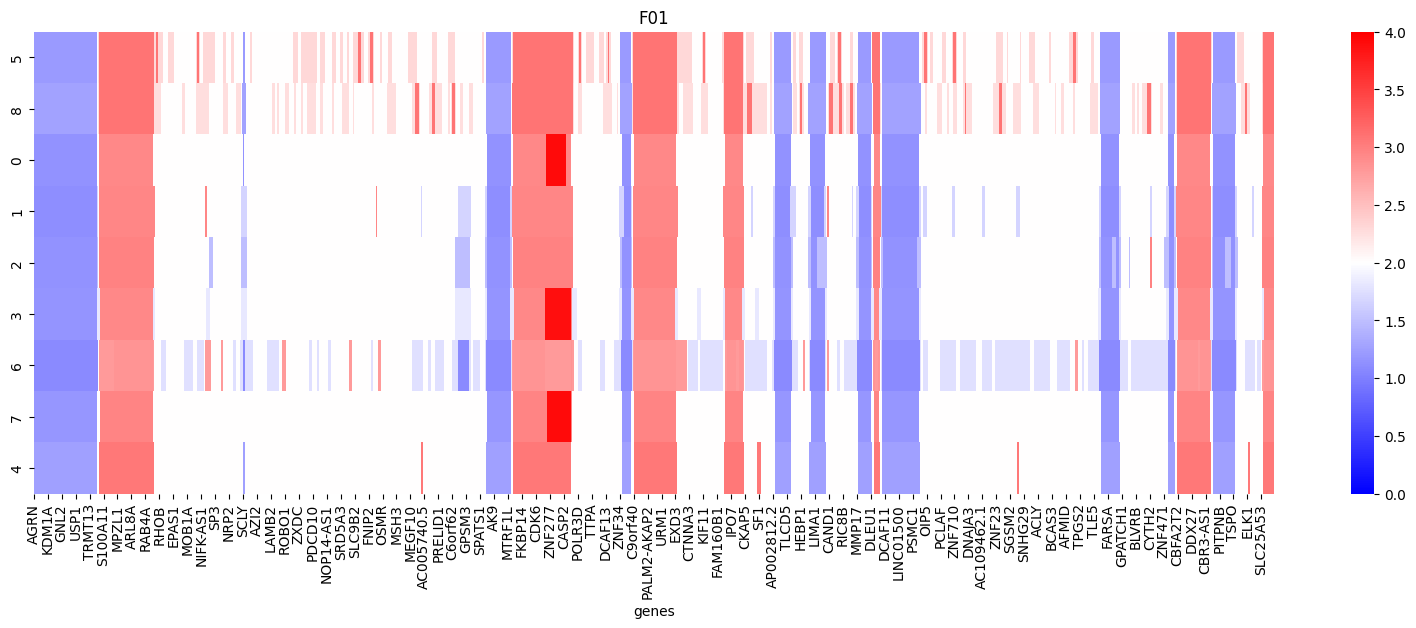

In [1012]:
for key in pt_states.keys():
    plt.figure(figsize=(20,6))
    plt.title(key)
    sns.heatmap(pt_states[key].T,cmap='bwr', vmax=4, vmin=0)

In [1046]:
pt_states["F16"]

0         1        5        8         2         9  \
genes                                                                  
ISG15       1.099867  1.449167  1.32641  0.92839  2.000000  2.000000   
AL645608.1  1.099867  1.449167  1.32641  0.92839  2.000000  2.000000   
AGRN        1.099867  1.449167  1.32641  0.92839  2.000000  2.000000   
AL645608.8  1.099867  1.449167  1.32641  0.92839  2.000000  2.000000   
C1orf159    1.099867  1.449167  1.32641  0.92839  2.000000  2.000000   
...              ...       ...      ...      ...       ...       ...   
MAMLD1      1.099867  1.449167  1.32641  0.57027  1.514401  1.553086   
MTM1        1.099867  1.449167  1.32641  0.57027  1.514401  1.553086   
MTMR1       1.099867  1.449167  1.32641  0.57027  1.514401  1.553086   
CD99L2      1.099867  1.449167  1.32641  0.57027  1.514401  1.553086   
HMGB3       1.099867  1.449167  1.32641  0.57027  1.514401  1.553086   

                   3         4         6         7  
genes                                               
ISG15       2.000000  2.000000  2.000000  2.000000  
AL645608.1  2.000000  2.000000  2.000000  2.000000  
AGRN        2.000000  2.000000  2.000000  2.000000  
AL645608.8  2.000000  2.000000  2.000000  2.000000  
C1orf159    2.000000  2.000000  2.000000  2.000000  
...              ...       ...       ...       ...  
MAMLD1      1.317063  1.547847  1.249578  0.274523  
MTM1        1.317063  1.547847  1.249578  0.274523  
MTMR1       1.317063  1.547847  1.249578  0.274523  
CD99L2      1.317063  1.547847  1.249578  0.274523  
HMGB3       1.317063  1.547847  1.249578  0.274523  

[25043 rows x 10 columns]

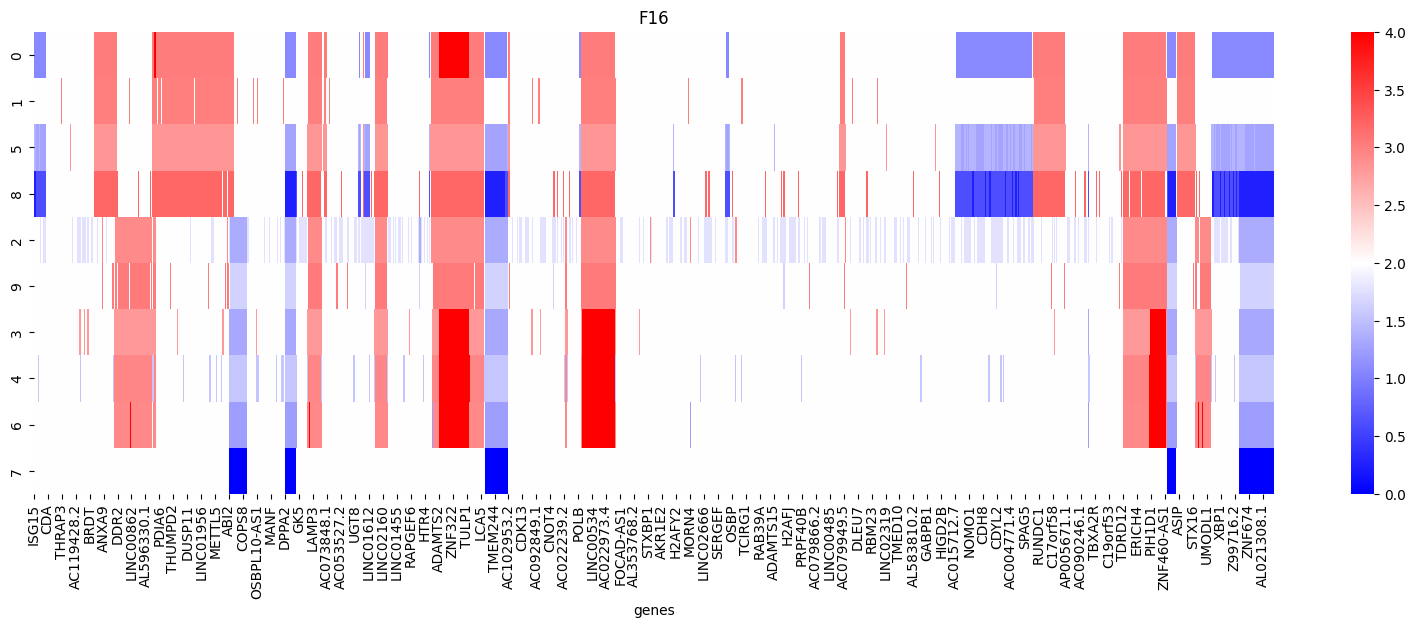

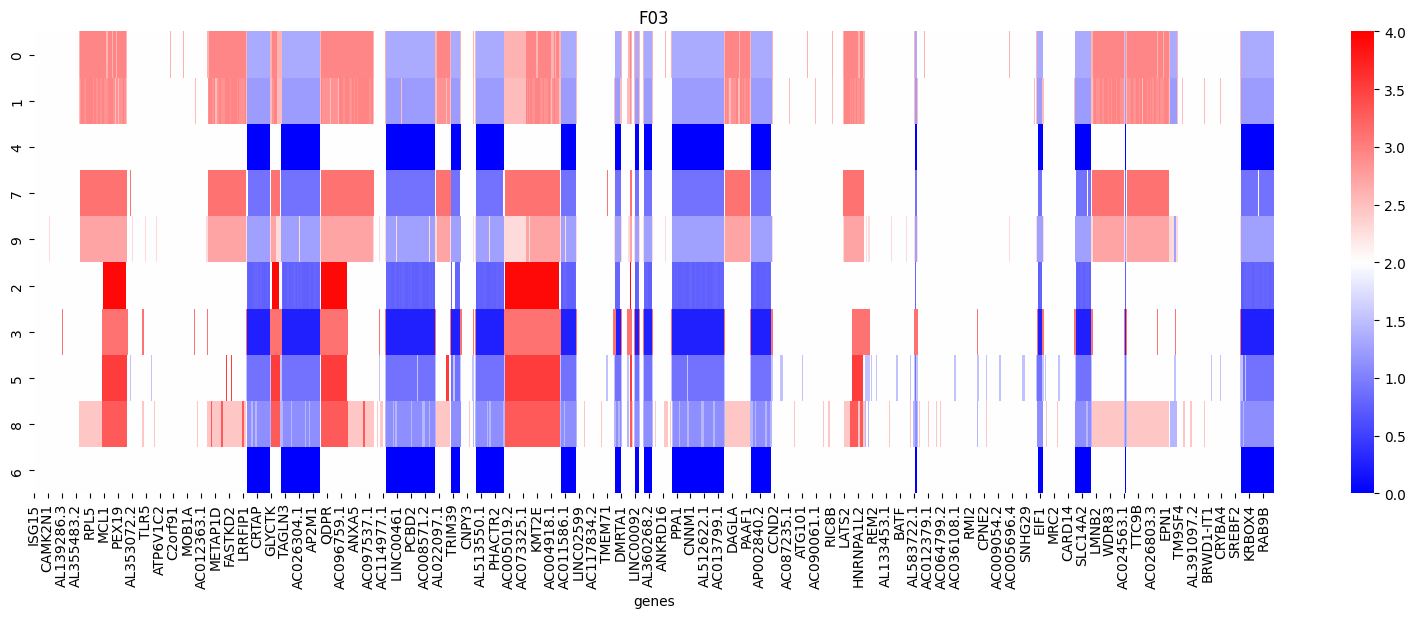

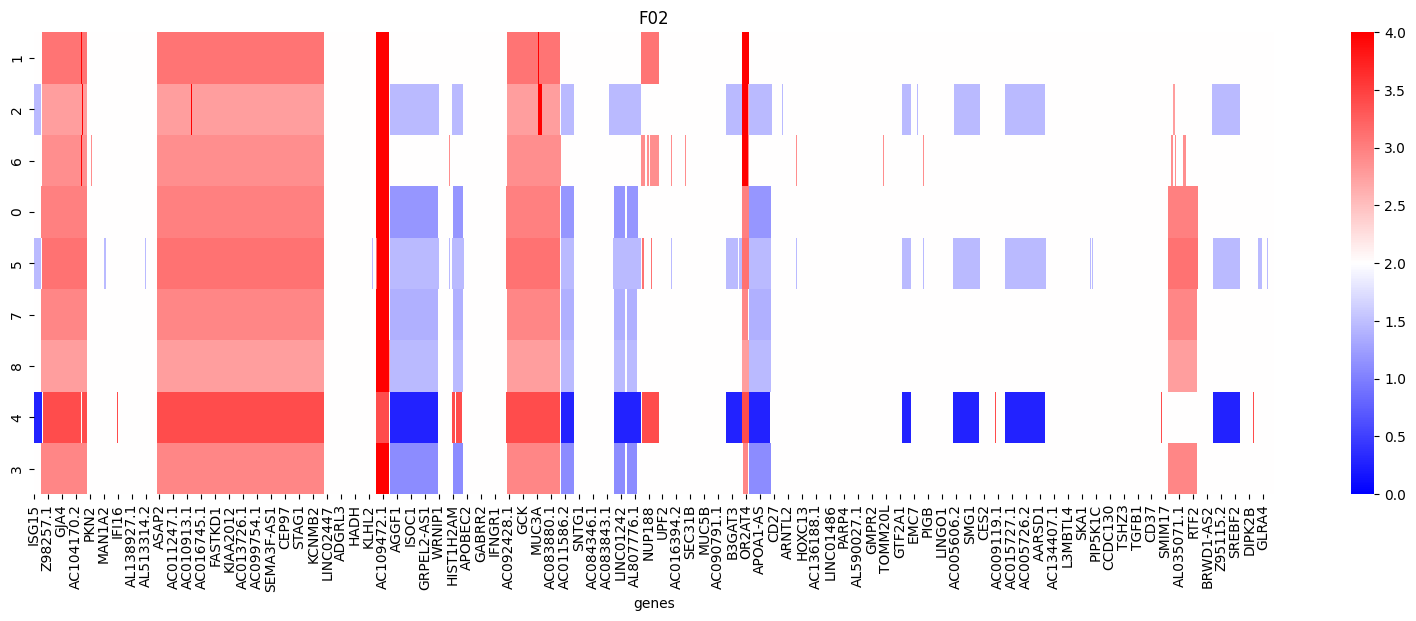

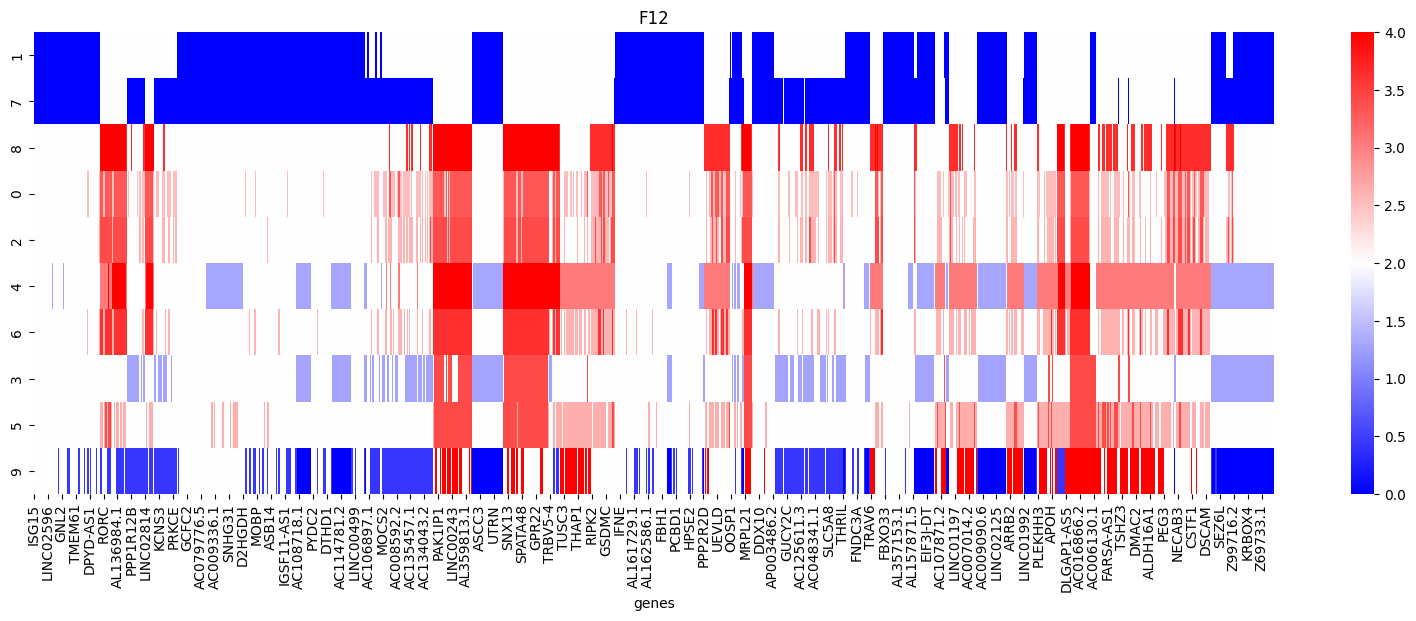

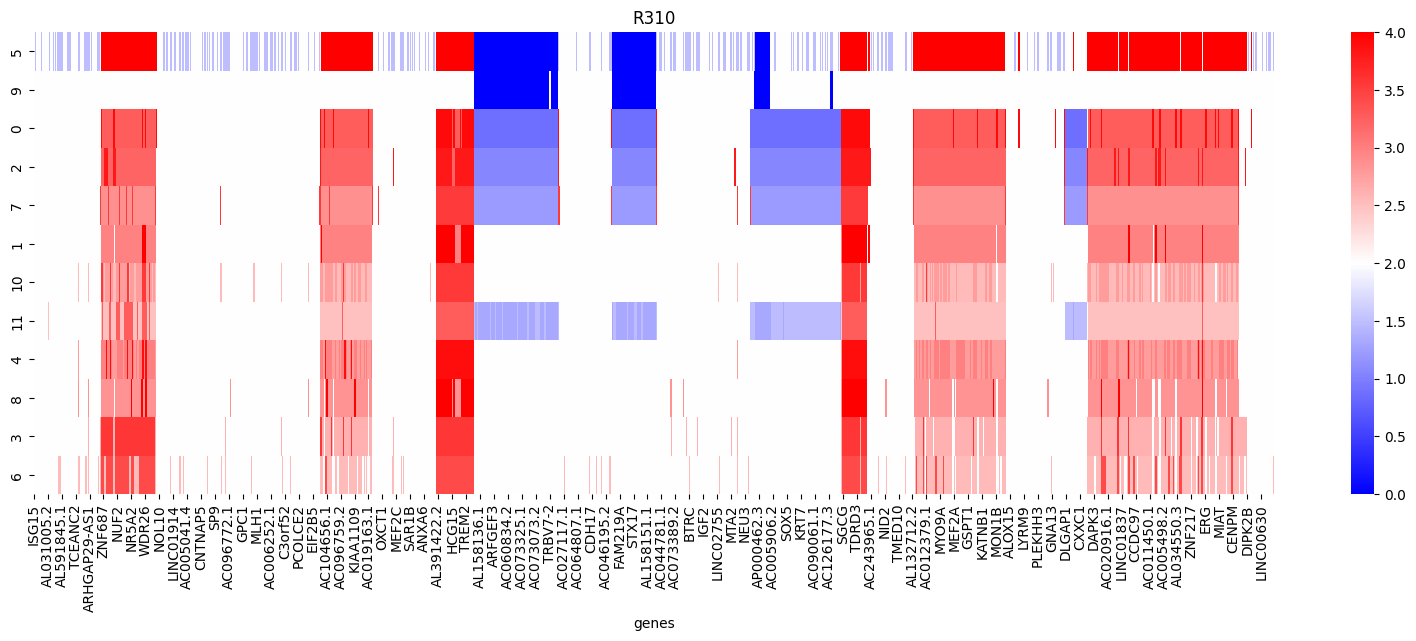

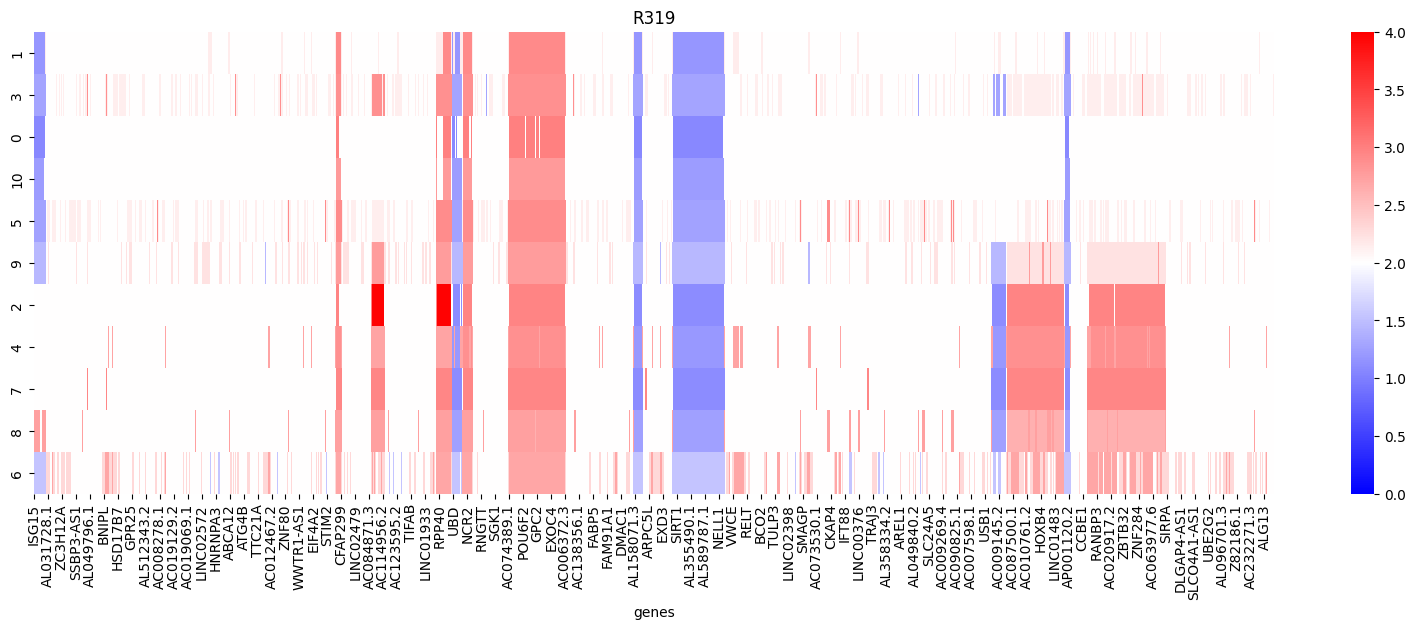

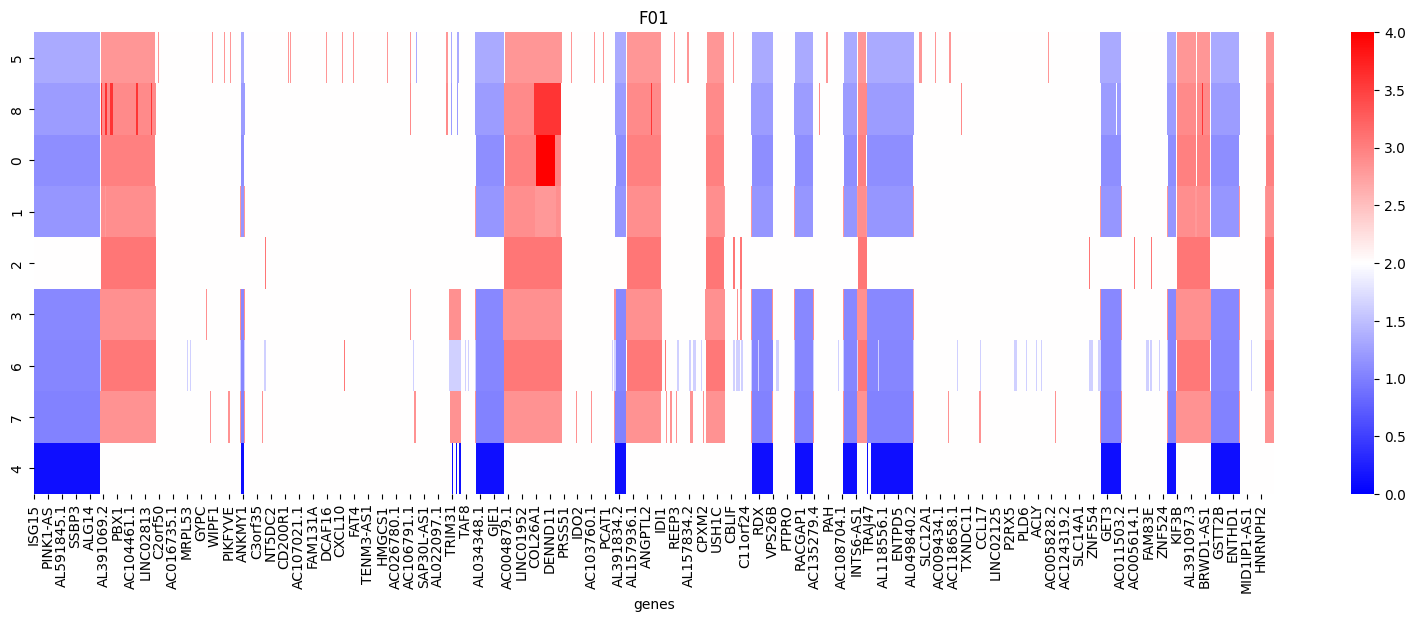

In [1061]:
for key in pt_states.keys():
    plt.figure(figsize=(20,6))
    plt.title(key)
    sns.heatmap(pt_states[key].T,cmap='bwr', vmax=4, vmin=0)

In [1024]:
pt_states["F16"]

0         1         5         8         2        9  \
genes                                                                  
ISG15      1.291787  1.271366  1.256423  1.256213  2.000000  2.00000   
AGRN       1.291787  1.271366  1.256423  1.256213  2.000000  2.00000   
C1orf159   1.291787  1.271366  1.256423  1.256213  2.000000  2.00000   
TNFRSF4    1.291787  1.271366  1.256423  1.256213  2.000000  2.00000   
SDF4       1.291787  1.271366  1.256423  1.256213  2.000000  2.00000   
...             ...       ...       ...       ...       ...      ...   
LINC00894  1.291787  1.271366  1.256423  1.256213  1.194659  2.51326   
MAMLD1     1.291787  1.271366  1.256423  1.256213  1.194659  2.51326   
MTM1       1.291787  1.271366  1.256423  1.256213  1.194659  2.51326   
MTMR1      1.291787  1.271366  1.256423  1.256213  1.194659  2.51326   
CD99L2     1.291787  1.271366  1.256423  1.256213  1.194659  2.51326   

                  3       4         6         7  
genes                                            
ISG15      2.000000  2.0000  2.000000  2.000000  
AGRN       2.000000  2.0000  2.000000  2.000000  
C1orf159   2.000000  2.0000  2.000000  2.000000  
TNFRSF4    2.000000  2.0000  2.000000  2.000000  
SDF4       2.000000  2.0000  2.000000  2.000000  
...             ...     ...       ...       ...  
LINC00894  1.169918  1.2986  1.286151  1.215812  
MAMLD1     1.169918  1.2986  1.286151  1.215812  
MTM1       1.169918  1.2986  1.286151  1.215812  
MTMR1      1.169918  1.2986  1.286151  1.215812  
CD99L2     1.169918  1.2986  1.286151  1.215812  

[12191 rows x 10 columns]

In [1069]:
import pickle

# Specify the filename
filename = 'pt_clone_dict.pkl'

# Open the file in binary write mode and dump the data into it
with open(filename, 'wb') as file:
    pickle.dump(pt_clone_dict, file)

In [1050]:
import pickle

# Specify the filename
filename = 'all_patients_UNFILTERED_hmm_etas.pkl'

# Open the file in binary write mode and dump the data into it
with open(filename, 'wb') as file:
    pickle.dump(pt_states, file)


In [756]:
vals = np.asarray(eta_smoothed.loc['11'])
cnvs = get_states(vals, transition=3)

Converged: True		Score: 5628.55652861052
Converged: True		Score: 6554.45611359995
Converged: True		Score: 5886.835597384221
Converged: True		Score: 8606.207705487453
Converged: True		Score: 6332.342358923649
Converged: True		Score: 7415.7803569015805
Converged: True		Score: 7741.634560895794
Converged: True		Score: 5887.969762784402
Converged: True		Score: 2228.3695869167273
Converged: True		Score: 7590.532724252421
The best model had a score of 8606.207705487453 and 7 components
0 0 1.0
0 1 0.0
0 2 0.0
0 3 5.748270150537572e-229
0 4 0.0
1 0 0.0
1 1 1.0
1 2 0.0
1 3 0.0
1 4 0.0
2 0 0.0
2 1 0.0
2 2 1.0
2 3 9.416911653059407e-244
2 4 0.0
3 0 5.748270150537572e-229
3 1 0.0
3 2 9.416911653059407e-244
3 3 1.0
3 4 1.7752269808549286e-242
4 0 0.0
4 1 0.0
4 2 0.0
4 3 1.7752269808549286e-242
4 4 1.0
neut [1.1812820113092861]
            vals  states       CNV
states                            
1.0     1.181282     1.0  2.000000
2.0     1.623153     2.0  2.441871
6.0     1.755343     6.0  2.57406

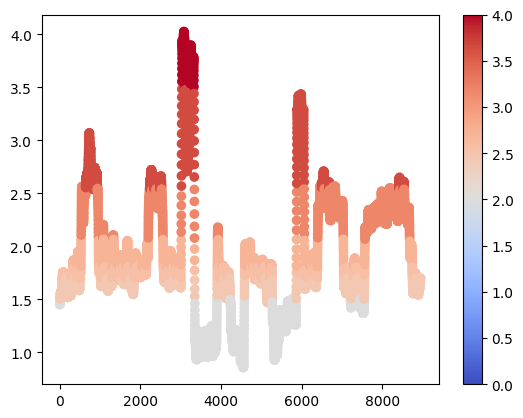

In [757]:
plt.scatter([i for i in range(len(vals))],vals, c=cnvs, cmap='coolwarm',vmax=4,vmin=0)
plt.colorbar()

In [735]:
h = pd.DataFrame()
for col in hm.columns:
    h[col] = [i for i in hm[col][0]]

<Axes: title={'center': 'Eta Genes'}>

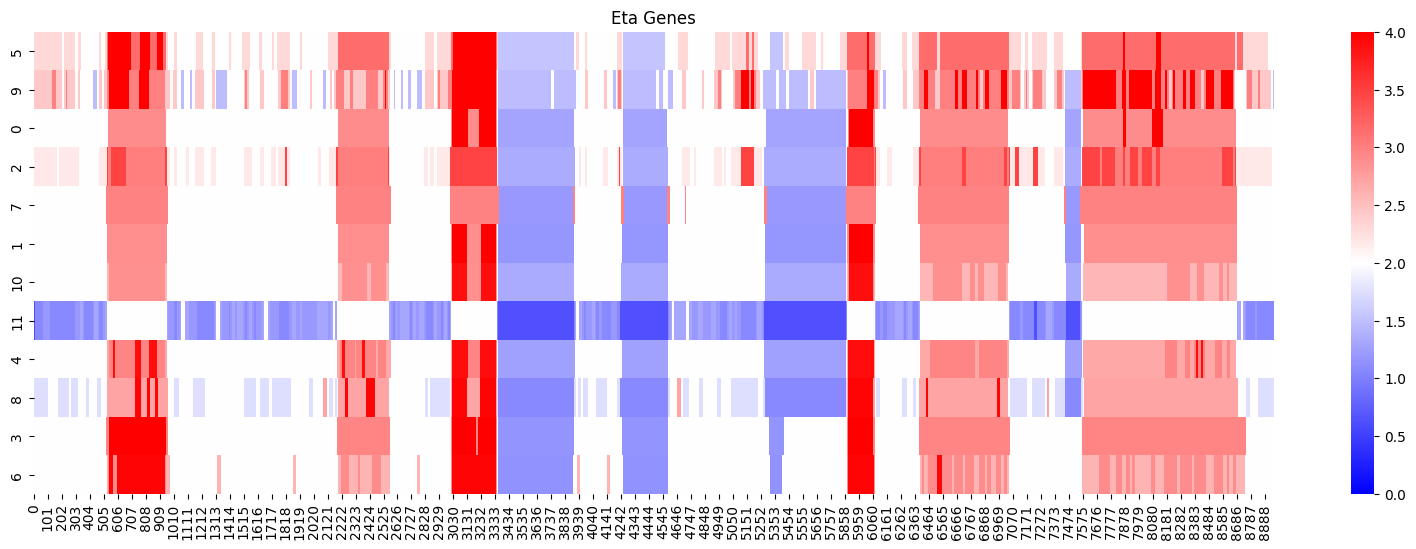

In [761]:
plt.figure(figsize=(20,6))
plt.title("Eta Genes")
sns.heatmap(h.T,cmap='bwr', vmax=4, vmin=0)

In [762]:
ad = sc.read_h5ad("params_mt_refined/R319/X.h5")
clust_order = []
obs = ad.obs
for i in np.unique(obs["eta_clones"]):
    clust_order+=list(np.unique(obs[obs["eta_clones"]==i]["leiden"]))

In [763]:
clust_order

['1', '3', '0', '10', '5', '9', '2', '4', '7', '8', '6']

In [489]:
infer_on = pd.read_csv("infercnv/R319_on_infercnv.csv", index_col=0)
infer_pre = pd.read_csv("infercnv/R319_pre_infercnv.csv", index_col=0)

In [490]:
Xad = sc.read_h5ad("params_mt_refined/R319/X.h5")
infercnv = pd.concat((infer_pre.loc[list(np.intersect1d(infer_pre.index, infer_on.index))], 
                      infer_on.loc[list(np.intersect1d(infer_pre.index, infer_on.index))]),axis=1).T

infer_inds = [i.split("-")[0] for i in infercnv.index]

infercnv.index = infer_inds

inds = pd.DataFrame(list(np.unique(infer_inds,return_counts=True)[0]))
inds["counts"]=np.unique(infer_inds,return_counts=True)[1]

inds = inds[inds['counts']==1]

infercnv = infercnv.loc[inds[0]]

X_inds = [i.split("-")[0] for i in Xad.obs_names]
Xad.obs_names=X_inds

x_inds = pd.DataFrame(list(np.unique(X_inds,return_counts=True)[0]))
x_inds["counts"]=np.unique(X_inds,return_counts=True)[1]
x_inds = x_inds[x_inds['counts']==1]

tmp_X = Xad.obs.loc[x_inds[0]]

clusters = pd.DataFrame(tmp_X["leiden"])
clusters.index = tmp_X.index

infercnv = infercnv.loc[np.intersect1d(x_inds[0],infercnv.index)]
clusters = clusters.loc[np.intersect1d(x_inds[0],infercnv.index)]

infercnv["clusters"]=clusters["leiden"]

infer_heatmap=pd.DataFrame()
for i in np.unique(infercnv["clusters"]):
    infer_heatmap[i]=np.mean(np.asarray(infercnv[infercnv["clusters"]==i].drop("clusters",axis=1)),axis=0)
infer_heatmap.index=infercnv.columns[:-1]

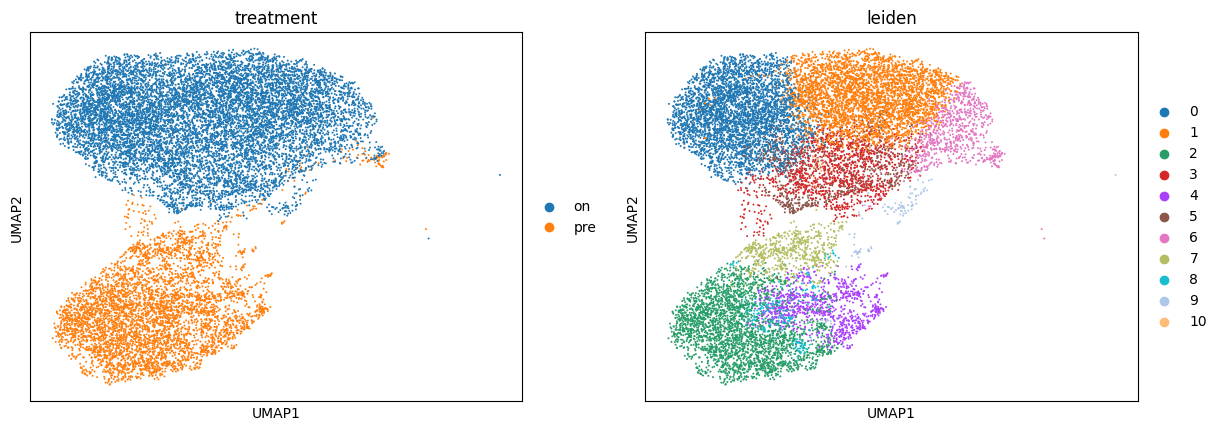

In [173]:
sc.pl.umap(Xad, color=["treatment","leiden"])

In [764]:
df = Xad.to_df()
var = pd.DataFrame(df.var())
var_filter = var[var[0]>.01]
ordered = [i for i in ordered_genes if i in intersect]

In [772]:
eta = pd.read_csv("params_mt_refined/R319/eta.csv",index_col=0).T

In [766]:
ordered_genes = np.load("ordered_genes.npy")

In [767]:
intersect = np.intersect1d(infer_heatmap.index, eta.columns)
ordered = [i for i in ordered_genes if i in intersect]

In [777]:
eta = eta[ordered]

Text(0.5, 1.0, 'inferCNV R319')

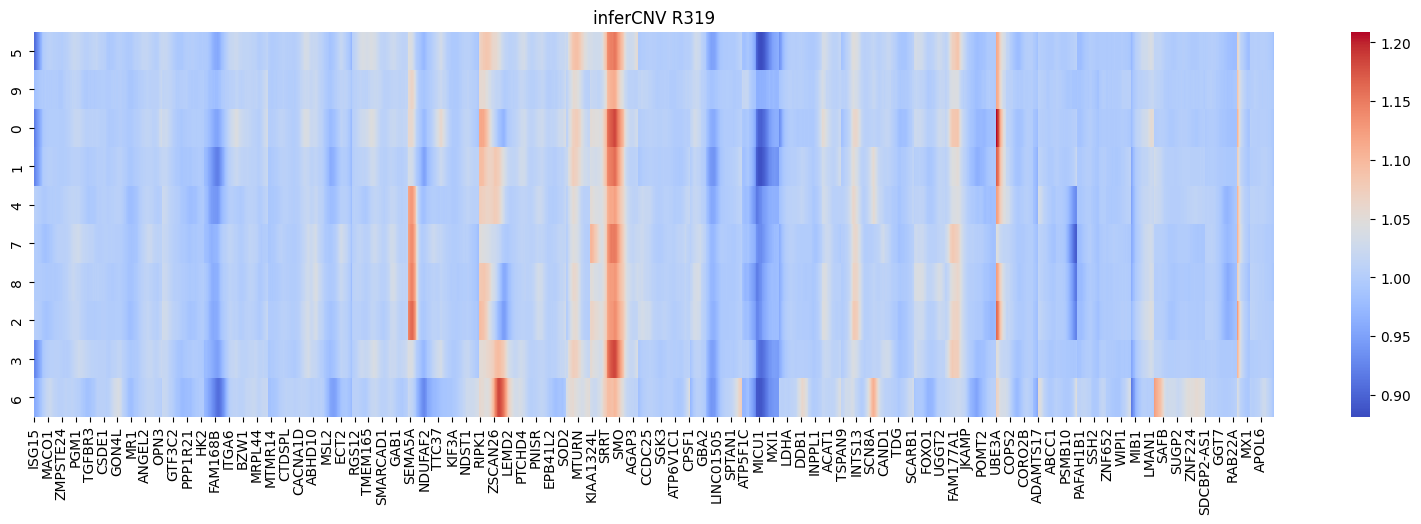

In [494]:
plt.figure(figsize=(20,5))
sns.heatmap(infer_heatmap.T[ordered].loc[['5','9','0','1','4','7','8','2','3','6']], cmap='coolwarm')
plt.title("inferCNV R319")

Text(0.5, 1.0, 'Eta R319')

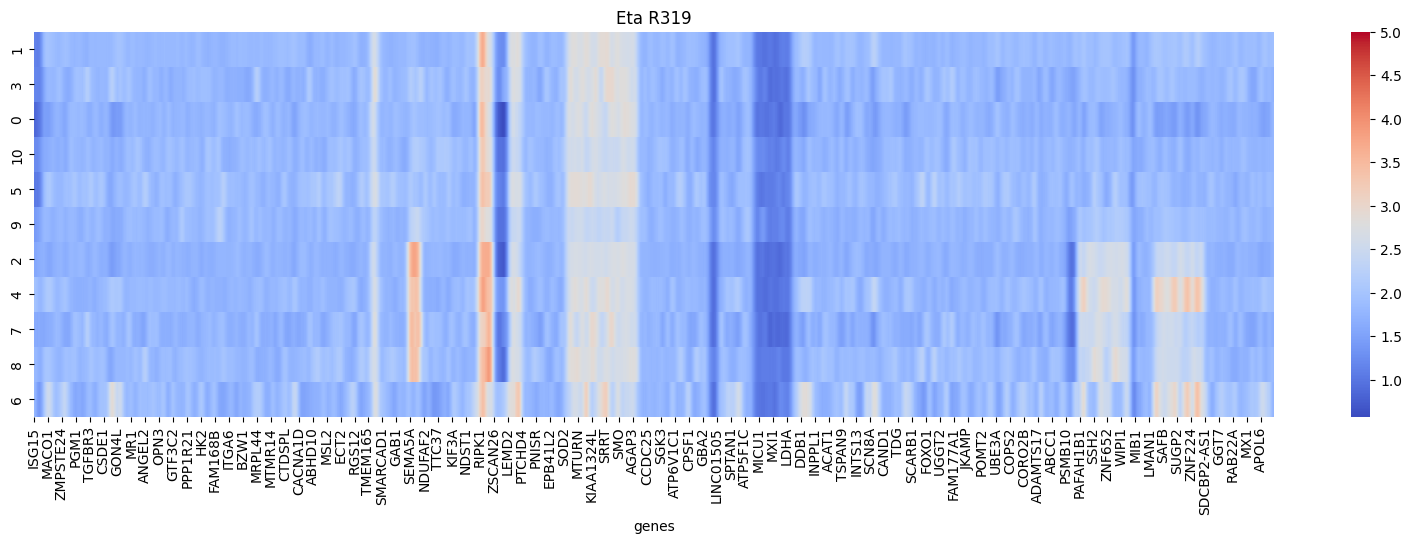

In [780]:
plt.figure(figsize=(20,5))
sns.heatmap(eta_smoothed, cmap='coolwarm',vmax=5)
plt.title("Eta R319")

In [778]:
eta_smoothed = scipy.ndimage.gaussian_filter1d(eta.loc[clust_order], sigma=10, axis=1, radius=20)
hm = pd.DataFrame()
eta_smoothed = pd.DataFrame(eta_smoothed, index=clust_order, columns=eta.columns)
for j in eta_smoothed.index:
    vals = np.asarray(eta_smoothed.loc[j])
    cnvs = get_states(vals, transition=3)
    hm[j]=[cnvs]

Converged: True		Score: 7225.320157134368
Converged: True		Score: 7061.121798520258
Converged: True		Score: 6935.114111258629
Converged: True		Score: 4984.51577325151
Converged: True		Score: 6933.983459617922
Converged: True		Score: 6938.94454957381
Converged: True		Score: 8460.179180100882
Converged: True		Score: 6780.908584608529
Converged: True		Score: 6933.625011441917
Converged: True		Score: 4918.129484836261
The best model had a score of 8460.179180100882 and 5 components
   0    1
3  3  217
1  1  174
0  0  167
4  4   75
2  2   69
Converged: True		Score: 6811.488484189691
Converged: True		Score: 6811.356376421937
Converged: True		Score: 5492.639660781951
Converged: True		Score: 5491.168650795547
Converged: True		Score: 5491.23533854958
Converged: True		Score: 3344.6949582144007
Converged: True		Score: 6811.391446802933
Converged: True		Score: 5491.366303282961
Converged: True		Score: 5491.058844187348
Converged: True		Score: 5493.275681026067
The best model had a score of 6811.48

<Axes: title={'center': 'Eta Genes'}>

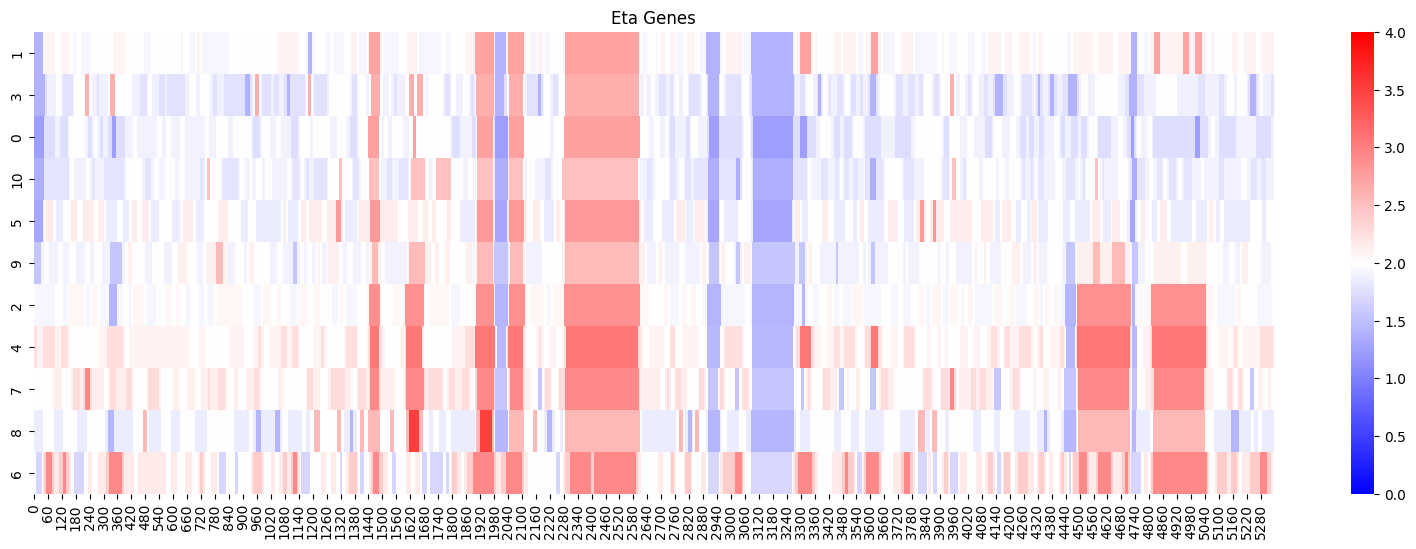

In [815]:
h = pd.DataFrame()
for col in hm.columns:
    h[col] = [i for i in hm[col][0]]

plt.figure(figsize=(20,6))
plt.title("Eta Genes")
sns.heatmap(h.T,cmap='bwr', vmax=4, vmin=0)

In [804]:
h.shape

(5336, 11)

In [817]:
h.columns = eta_smoothed.index
h.index = eta_smoothed.columns

In [819]:
h.to_csv("r319_amp_del_eta.csv")

In [538]:
c_pre = pd.read_csv("params_mt_refined/R319/c_pre.csv", index_col=0)

In [278]:
eta = eta[ordered]

In [513]:
peek_del = eta.columns[11730:11830]

<Axes: xlabel='genes'>

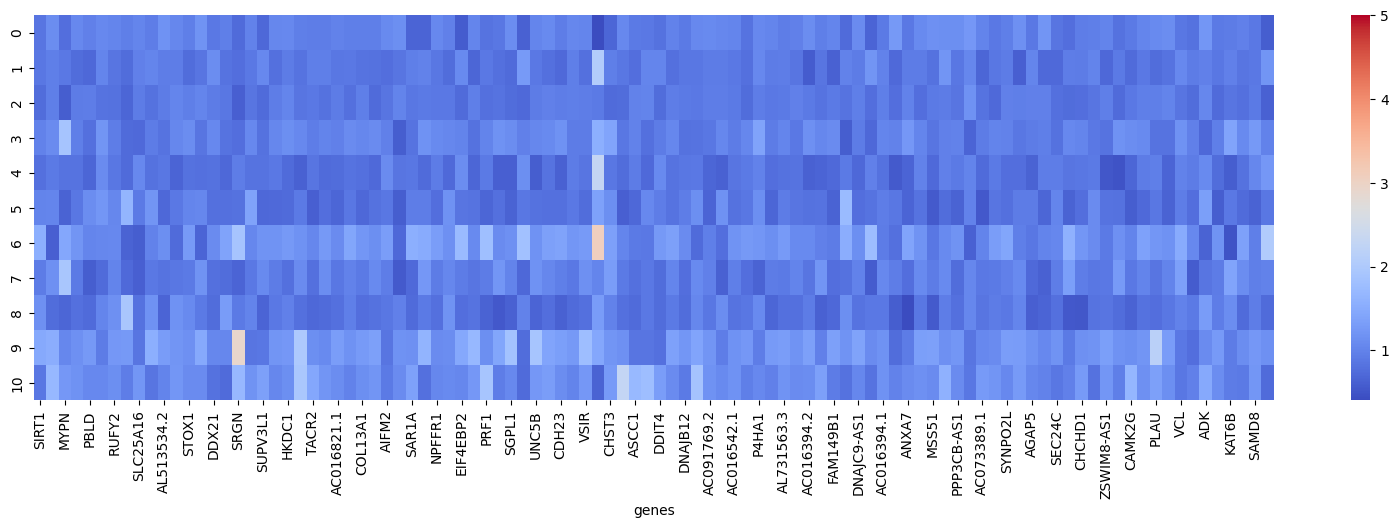

In [512]:
plt.figure(figsize=(20,5))
sns.heatmap(eta.iloc[:,11730:11830], cmap='coolwarm',vmax=5)

In [448]:
peek = ['CLPTM1L', 'LPCAT1', 'LINC01019', 'ICE1', 'MED10', 'NSUN2', 'SRD5A1',
       'TENT4A', 'MTRR', 'AC091912.3', 'SEMA5A', 'CCT5', 'MARCH6', 'DAP',
       'TRIO', 'OTULIN', 'FBXL7', 'MYO10', 'AC106744.1', 'LINC02241',
       'C5orf17', 'LINC02228', 'LINC02211', 'PURPL', 'AC008825.1', 'LINC02109',
       'DROSHA', 'C5orf22', 'PDZD2', 'GOLPH3', 'MTMR12', 'ZFR', 'SUB1', 'TARS',
       'SLC45A2', 'NADK2', 'NIPBL', 'CPLANE1', 'NUP155', 'WDR70', 'OSMR',
       'RICTOR', 'FYB1', 'DAB2', 'PRKAA1', 'OXCT1', 'C5orf51', 'AC025171.2',
       'ZNF131', 'CCL28', 'TMEM267', 'PAIP1', 'NNT', 'MRPS30-DT', 'MRPS30']

# Correlations in R319

In [602]:
c_on = pd.read_csv("params_mt_refined/R319/c_on.csv",index_col=0)

In [444]:
ip = pd.read_csv("spearman_mt_8.1.24.csv", index_col=0).dropna()

In [781]:
ming_ip = pd.read_csv("corr_WLS_reg.csv", index_col=0)

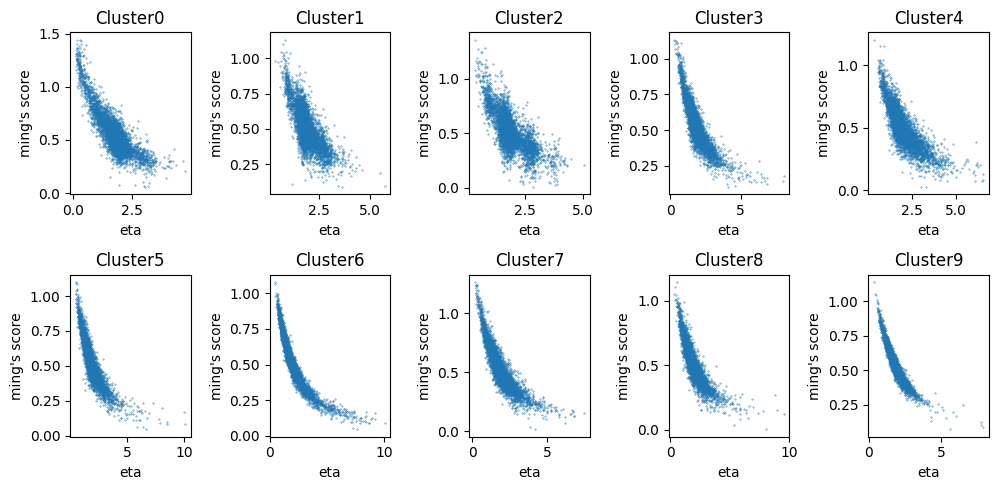

In [798]:
fig,ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    ax[i//5][i%5].scatter(eta.loc[str(i)],ming_ip[str(i)].loc[eta.columns], s=.1)
    ax[i//5][i%5].set_title("Cluster" +str(i))
    ax[i//5][i%5].set_xlabel("eta")
    ax[i//5][i%5].set_ylabel("ming's score")
plt.tight_layout()

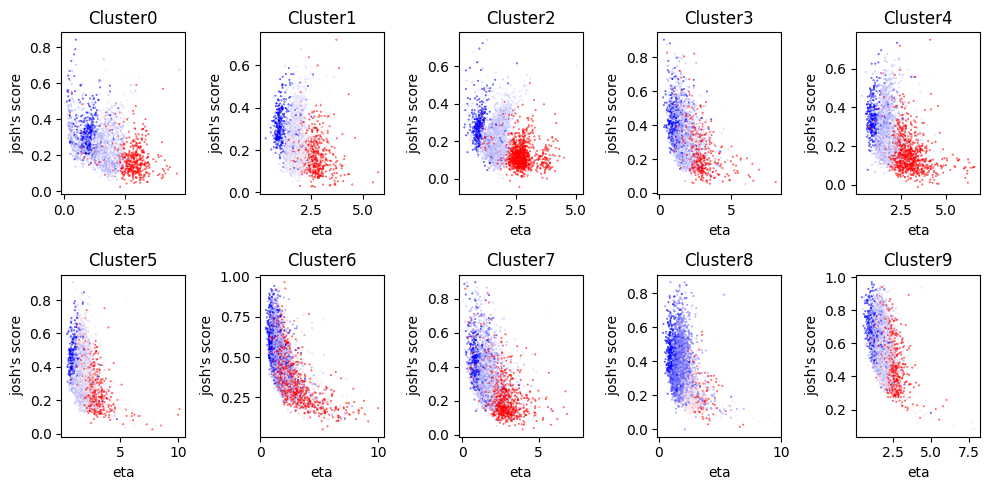

In [809]:
fig,ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    ints = np.intersect1d(eta.columns, ip.index)
    ax[i//5][i%5].scatter(eta.loc[str(i)][ints],ip["R319_"+str(i)].loc[ints], s=.1, c=h.loc[ints][str(i)], cmap='bwr')
    ax[i//5][i%5].set_title("Cluster" +str(i))
    ax[i//5][i%5].set_xlabel("eta")
    ax[i//5][i%5].set_ylabel("josh's score")
plt.tight_layout()

In [1227]:
eta_mean = pd.read_csv("params_mt_refined/R310/eta.csv",index_col=0).loc[ip.index]
cov = np.load("params_mt_refined/R310/cov.npy")

In [1228]:
c_pre = pd.read_csv("params_mt_refined/R310/c_pre.csv",index_col=0).loc[ip.index]

In [1229]:
eta_samples = sample_Eta(torch.Tensor(np.asarray(eta_mean)), torch.Tensor(cov))

In [1230]:
c_shape = pd.read_csv("params_mt_refined/R310/c_shape.csv",index_col=0).loc[ip.index]
c_shape = torch.Tensor(np.asarray(c_shape)).T.unsqueeze(1)
c_samples = sample_p_c_cond_eta(eta_samples, c_shape, 0, 5)

In [1197]:
ip = pd.read_csv("var_exp_mt.csv", index_col=0).dropna()

In [1198]:
#pd.DataFrame(ip["R310_5"]).sort_values(by='R310_5', ascending=False).to_csv("IP_R319_2.rnk", sep='\t')

In [670]:
colors = []
for i in ip.index:
    if i in peek:
        colors.append("red")
    elif i in peek_del:
        colors.append("blue")
    elif i in highest:
        colors.append("green")
    else: 
        colors.append("grey")

Text(0.5, 1.0, 'IP score vs eta')

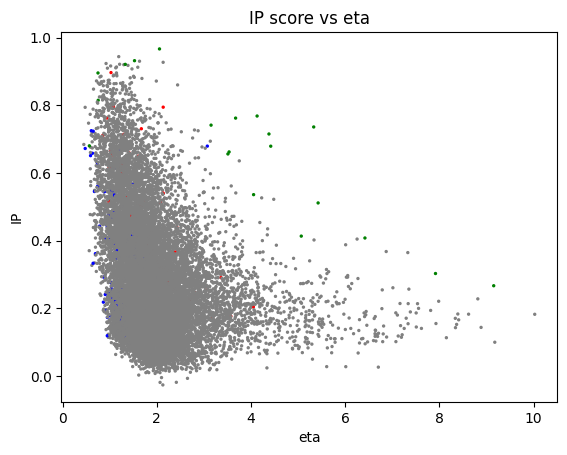

In [677]:
plt.scatter(eta.loc['6'][ip.index],ip["R319_6"], s=2, c=colors)
plt.xlabel("eta")
plt.ylabel("IP")
plt.title("IP score vs eta")

In [1214]:
highest = pd.DataFrame(abs(ip["R310_5"])).sort_values(by='R310_5', ascending=False)[0:20].index

In [1238]:
ip["R310_5"]

genes
ISG15         0.844841
AGRN          0.297544
C1orf159     -0.341147
AL390719.3    0.869583
TNFRSF18      0.923157
                ...   
MAMLD1       -0.581923
MTM1         -0.362510
MTMR1        -0.254606
CD99L2        0.273133
HMGB3         0.884506
Name: R310_5, Length: 19415, dtype: float64

In [1301]:
eta_var = []
c_var = []
for i in range(ip.shape[0]):
    eta_var.append(np.var(np.asarray(eta_samples[:,i,5])))
    c_var.append(np.var(np.log(np.asarray(c_samples[:,i]))))

In [1258]:
big_inds = []
small_inds = []
for i in range(len(abs(ip["R310_5"]))):
    if abs(ip["R310_5"])[i]>.9: 
        big_inds.append(i)
    elif abs(ip["R310_5"])[i]<.7: 
        small_inds.append(i)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_25125/318742458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(ip["R310_5"])[i]>.9:
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_25125/318742458.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(ip["R310_5"])[i]<.7:


In [1302]:
eta_var = np.asarray(eta_var)
c_var = np.asarray(c_var)

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(


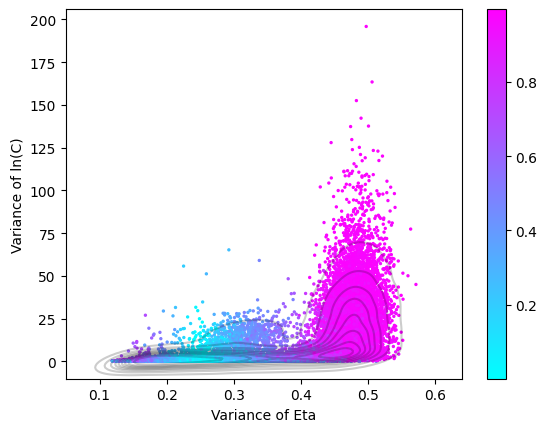

In [1305]:
# Add contour density lines
sns.kdeplot(x=eta_var, y=c_var, fill=False, thresh=0.05, c='black', alpha=.2)
plt.scatter(eta_var, c_var, c=abs(ip["R310_5"]),s=2, cmap='cool')
plt.xlabel("Variance of Eta")
plt.ylabel("Variance of ln(C)")
plt.colorbar()

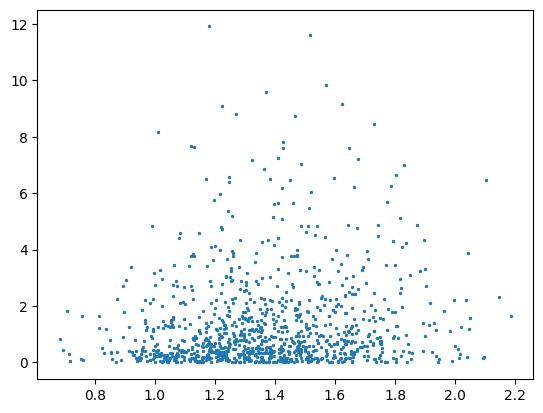

In [1213]:
gene='GBP2'
plt.scatter(eta_samples[:,list(eta_mean.index).index(gene),2],
            c_samples[:,list(eta_mean.index).index(gene)], s=2)
#plt.title(gene+" in growing cluster: IP="+str(round(ip["R319_2"].loc[gene],3))+", eta="+str(eta.loc['2'][gene]))

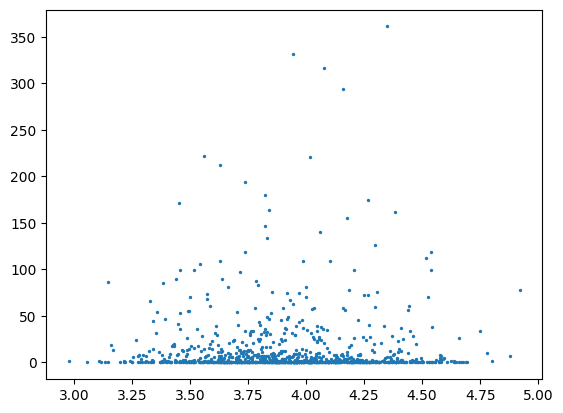

In [1219]:
gene='TSBP1-AS1'
plt.scatter(eta_samples[:,list(eta_mean.index).index(gene),2],
            c_samples[:,list(eta_mean.index).index(gene)], s=2)

In [610]:
ip[['R319_2','R319_4','R319_7','R319_8']].loc["LPCAT1"]

R319_2    0.083580
R319_4    0.087884
R319_7    0.197747
R319_8    0.231387
Name: LPCAT1, dtype: float64

In [611]:
ip[['R319_0','R319_1','R319_3','R319_5','R319_6','R319_9']].loc["LPCAT1"]

R319_0    0.256089
R319_1    0.227631
R319_3    0.259705
R319_5    0.293078
R319_6    0.365895
R319_9    0.534300
Name: LPCAT1, dtype: float64

In [593]:
eta_mean['2'].loc["LPCAT1"]

3.630324

In [604]:
c_on['2'].loc["LPCAT1"]

13.298997

Text(0.5, 1.0, 'LPCAT1 in shrinking cluster: IP=0.534')

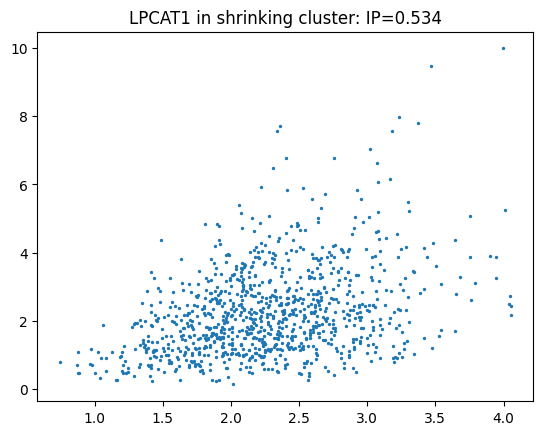

In [618]:
plt.scatter(eta_samples[:,list(eta_mean.index).index("LPCAT1"),9],
            c_samples[:,list(eta_mean.index).index("LPCAT1")], s=2)
plt.title("LPCAT1 in shrinking cluster: IP="+str(round(ip["R319_9"].loc["LPCAT1"],3)))

In [619]:
eta_mean['9'].loc["LPCAT1"]

2.1502235

In [621]:
c_pre['9'].loc["LPCAT1"]

6.955693

Text(0.5, 1.0, 'RPP40 in growing cluster: IP=0.031')

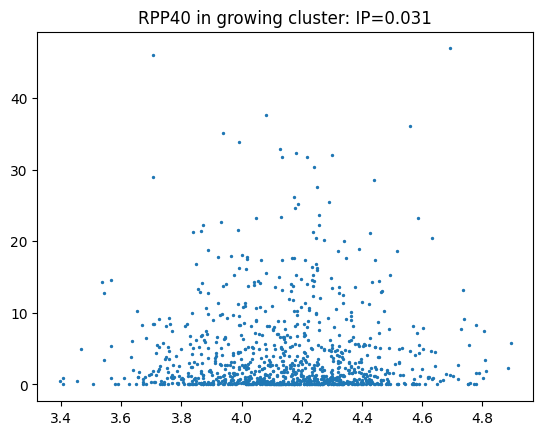

In [590]:
plt.scatter(eta_samples[:,list(eta_mean.index).index("RPP40"),2],
            c_samples[:,list(eta_mean.index).index("RPP40")], s=2)
plt.title("RPP40 in growing cluster: IP="+str(round(ip["R319_2"].loc["RPP40"],3)))

In [594]:
eta_mean['2'].loc["RPP40"]

4.1398063

In [606]:
c_on['2'].loc["RPP40"]

2.5547347

In [562]:
def sample_Eta(eta_mean, cov, sample_size=1000):
    eta_posterior = dist.MultivariateNormal(eta_mean, covariance_matrix=cov)
    samples = eta_posterior.sample([sample_size])
    return torch.nn.functional.softplus(samples)

import pyro.distributions as dist
def sample_p_c_cond_eta(eta_samples, c_shape, target_timepoint, cluster_idx, normalize=True):
    c_shape = c_shape[target_timepoint, :, :].squeeze()
    c_samples = dist.Gamma(c_shape, 1/eta_samples[:, :, cluster_idx]).sample()
    if normalize:
        return c_samples/c_shape
    else:
        return c_samples

<Axes: >

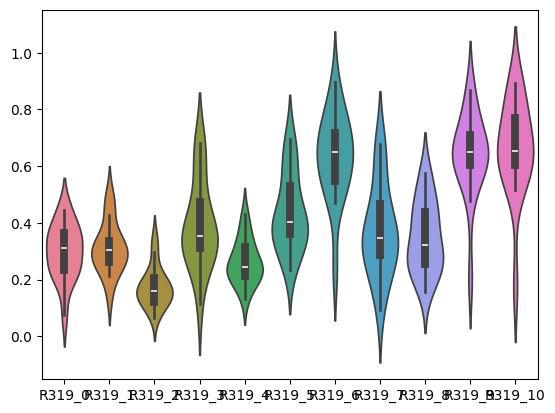

In [549]:
sns.violinplot(ip[[i for i in ip.columns if "R319" in i]].loc[filtered])

<Axes: >

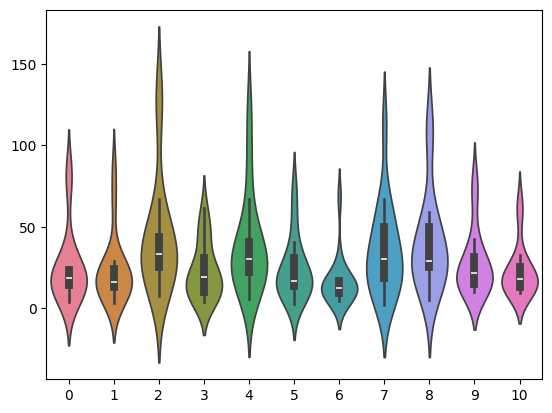

In [551]:
sns.violinplot(c_pre.loc[filtered])

<Axes: >

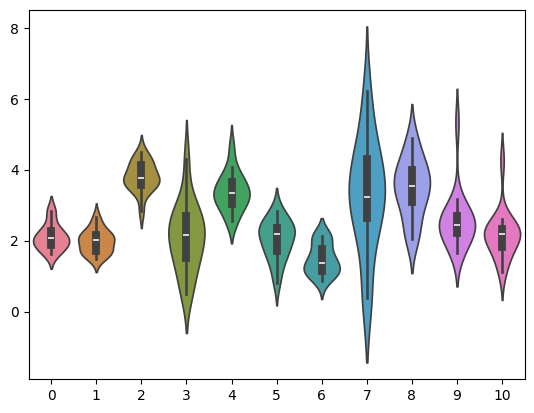

In [555]:
sns.violinplot(eta[filtered].T)

<Axes: >

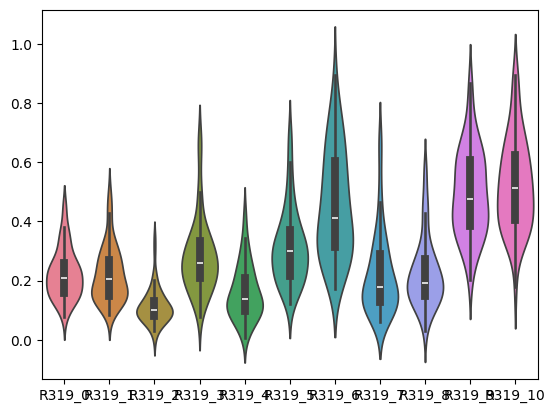

In [452]:
sns.violinplot(ip[[i for i in ip.columns if "R319" in i]].loc[peek])

<Axes: >

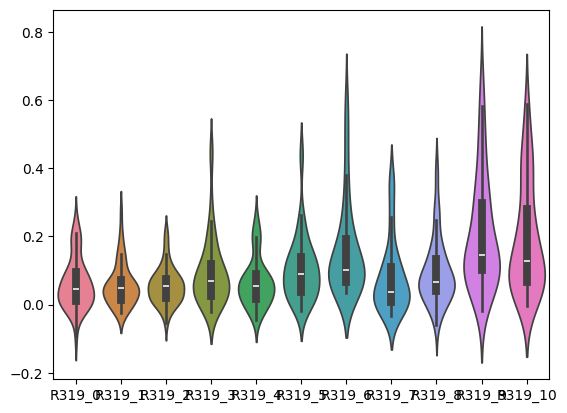

In [510]:
sns.violinplot(ip[[i for i in ip.columns if "R319" in i]].loc[np.intersect1d(peek2,ip.index)])

<Axes: >

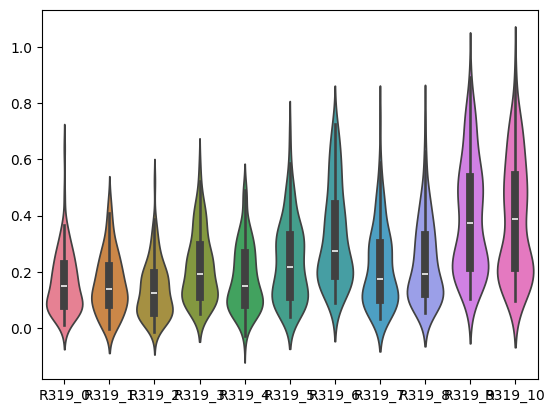

In [515]:
sns.violinplot(ip[[i for i in ip.columns if "R319" in i]].loc[np.intersect1d(peek_del,ip.index)])

<Axes: >

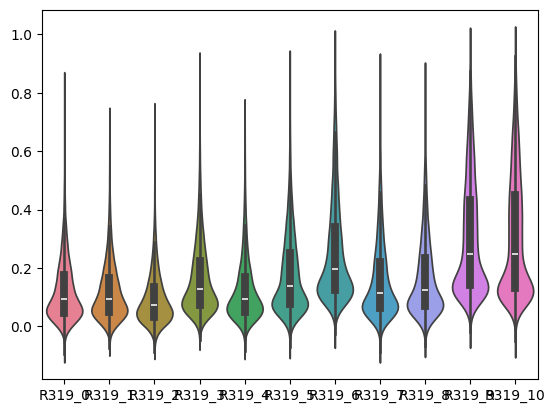

In [480]:
sns.violinplot(ip[[i for i in ip.columns if "R319" in i]])

In [457]:
def get_exp_per_geneset(genes):
    PATH = "params_mt_refined/"
    imm_reg_res = pd.DataFrame(index = genes)
    for patient in os.listdir("params_mt_refined/"):
        if "DS" not in patient and "_" not in patient:
    #         print(patient)
    #         path = os.path.join(PATH, patient)
    #         #eta = pd.read_csv(os.path.join(path + "/eta.csv"), index_col=0)
    #         ad = sc.read_h5ad(os.path.join(path + "/X.h5"))
    #         obs = ad.obs
    #         df = ad.to_df()
    #         clusters = np.unique(obs["leiden"])

    #         for cluster in clusters:
    #             dat = []
    #             for gene in genes:
    #                 if gene in df.columns:
    #                     dat.append(df.loc[obs[obs["leiden"]==cluster].index][gene].mean())
    #                 else:
    #                     dat.append(0)
    #             tmp = pd.DataFrame(dat, index=genes, columns=[patient+"_"+cluster])
    #             imm_reg_res = pd.concat((imm_reg_res, tmp),axis=1)
                
    # return imm_reg_res

            print(patient)
            path = os.path.join(PATH, patient)
            ad = sc.read_h5ad(os.path.join(path, "X.h5"))
            obs = ad.obs
            df = ad.to_df()

            clusters = np.unique(obs["leiden"])
            for cluster in clusters:
                dat = []
                for gene in genes:
                    if gene in df.columns:
                        cluster_indices = obs.index[obs["leiden"] == cluster]
                        cluster_means = df.loc[cluster_indices, gene].mean(axis=0)
                        dat.append(cluster_means)
                    else:
                        dat.append(0)
                tmp = pd.DataFrame(dat, index=genes, columns=[patient+"_"+cluster])
                imm_reg_res = pd.concat((imm_reg_res, tmp),axis=1)
                        #tmp = pd.DataFrame(cluster_means, columns=[patient + "_" + cluster])
                        #imm_reg_res = pd.concat((imm_reg_res, tmp), axis=1)
    
    return imm_reg_res

In [458]:
exp = get_exp_per_geneset(peek)

F16
F03
F02


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


F12
R310
R319
F01


Text(0.5, 1.0, 'expression of signature')

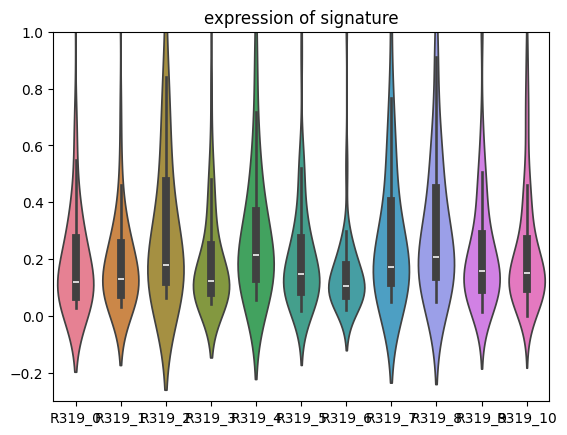

In [479]:
sns.violinplot(exp[[i for i in ip.columns if "R319" in i]])
plt.ylim([-.3,1])
plt.title("expression of signature")

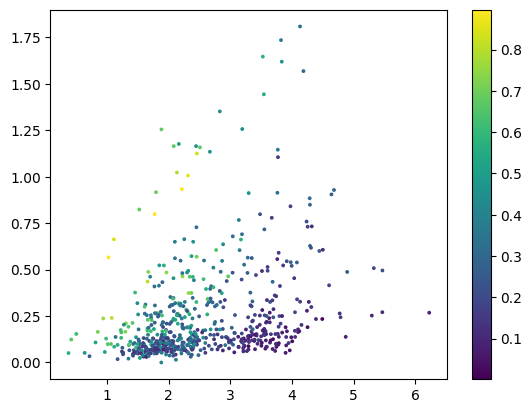

In [532]:
plt.scatter(np.asarray(eta[exp.index].T).flatten(),np.asarray(exp[[i for i in ip.columns if "R319" in i]]).flatten(),s=3,
           c=np.asarray(ip.loc[exp.index][[i for i in ip.columns if "R319" in i]]).flatten())#np.asarray(vardf).flatten())
plt.colorbar()

In [545]:
vardf = pd.DataFrame()
for i in eta.index:
    vardf[i]=exp[[i for i in ip.columns if "R319" in i]].var(axis=1)

In [548]:
var_filter = pd.DataFrame(exp[[i for i in ip.columns if "R319" in i]].var(axis=1))
filtered = var_filter[var_filter[0]>.01].index

In [467]:
stat_pal = {"growing":"red","stable":"yellow","shrinking":"green"}
stat_colors = [stat_pal[i] for i in echid_status[0]]

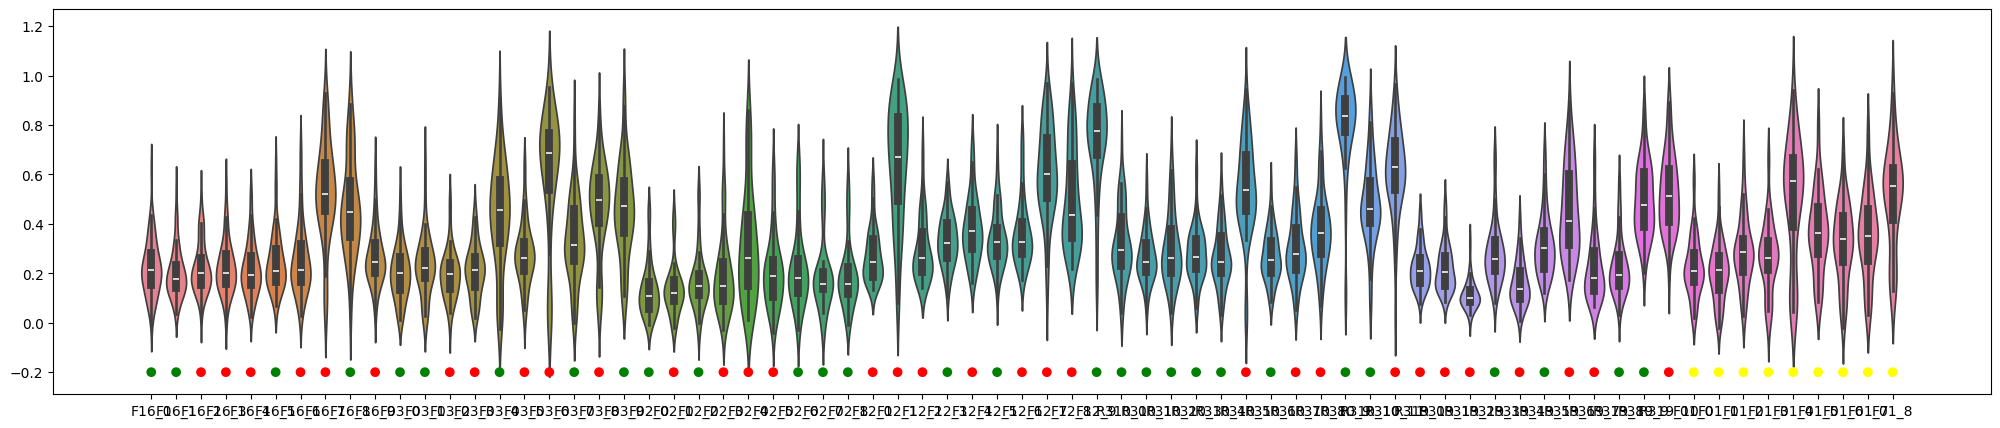

In [477]:
plt.figure(figsize=(25,5))
ax = sns.violinplot(ip.loc[peek])

x_coords = []
for collection in ax.collections:
    # collection.get_paths() returns a list of Path objects for each part of the violin
    for path in collection.get_paths():
        # The vertices of the path contain x, y coordinates; we are interested in the x-coordinates
        x = path.vertices[:, 0]
        x_coords.append(np.mean(x))

plt.scatter(x_coords,[-.2 for i in range(len(x_coords))], c=stat_colors)

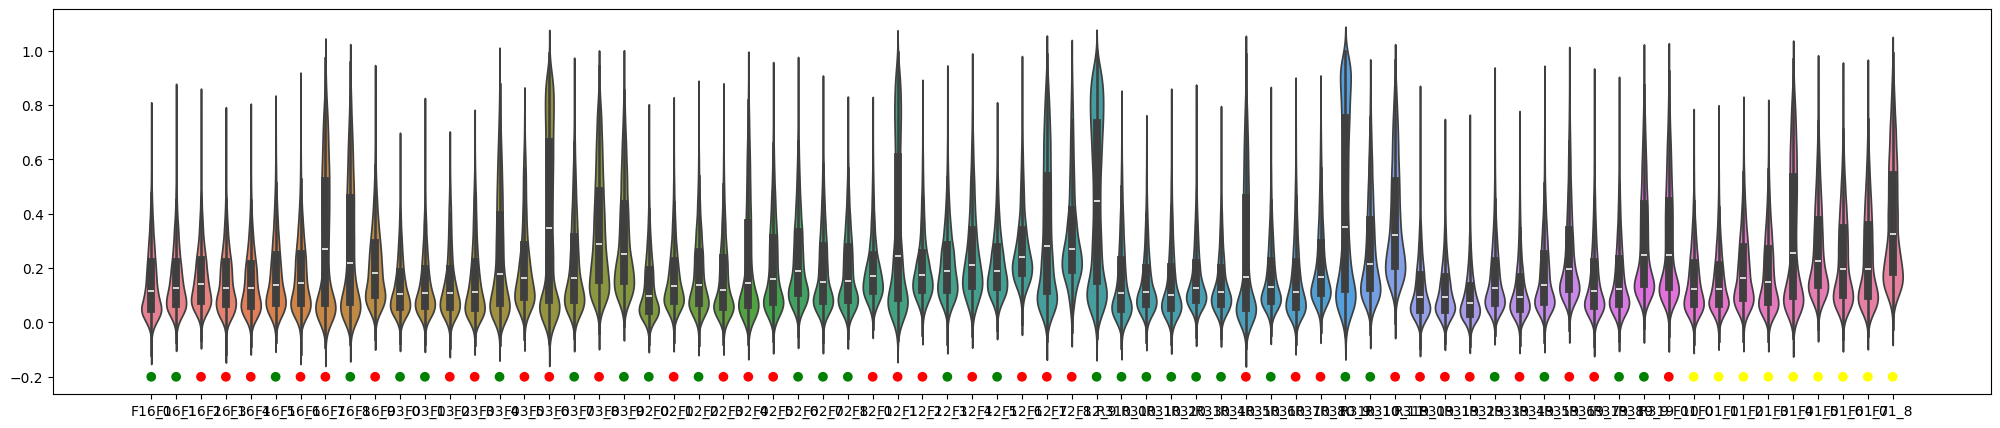

In [478]:
plt.figure(figsize=(25,5))
ax = sns.violinplot(ip)

x_coords = []
for collection in ax.collections:
    # collection.get_paths() returns a list of Path objects for each part of the violin
    for path in collection.get_paths():
        # The vertices of the path contain x, y coordinates; we are interested in the x-coordinates
        x = path.vertices[:, 0]
        x_coords.append(np.mean(x))

plt.scatter(x_coords,[-.2 for i in range(len(x_coords))], c=stat_colors)

Text(0.5, 1.0, 'eta R319')

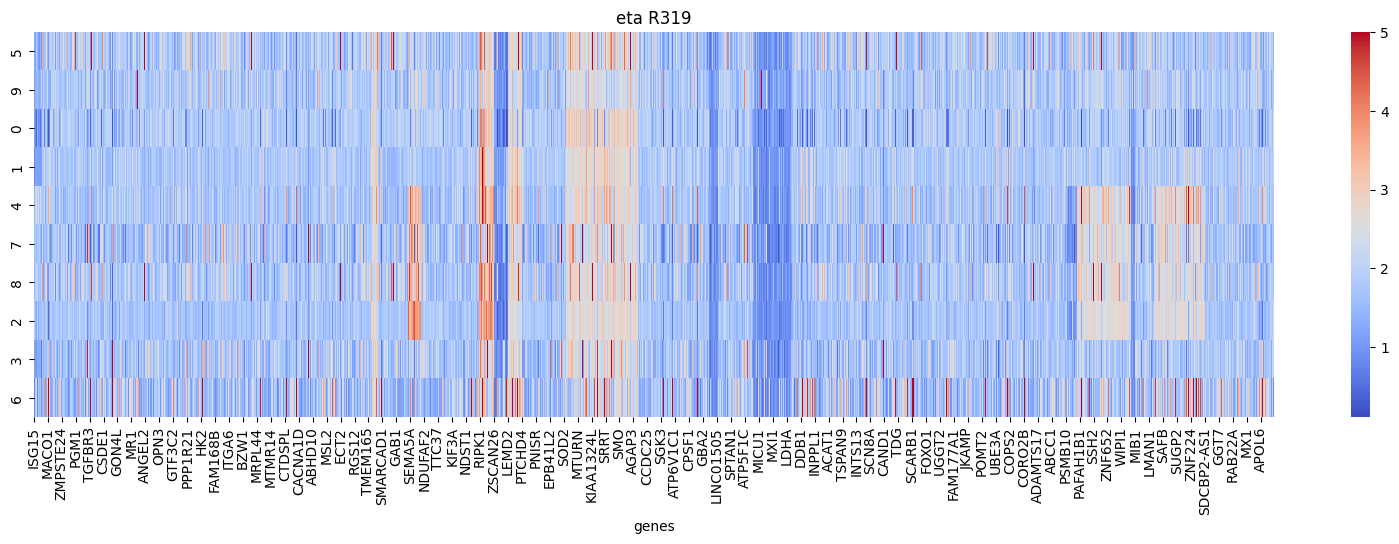

In [182]:

plt.figure(figsize=(20,5))
sns.heatmap(eta[ordered].loc[['5','9','0','1','4','7','8','2','3','6']], cmap='coolwarm', vmax=5)
plt.title("eta R319")

In [191]:
eta = eta[ordered]#.loc[['5','9','0','1','4','8','2','3','6']]

In [192]:
eta.shape[0]

11

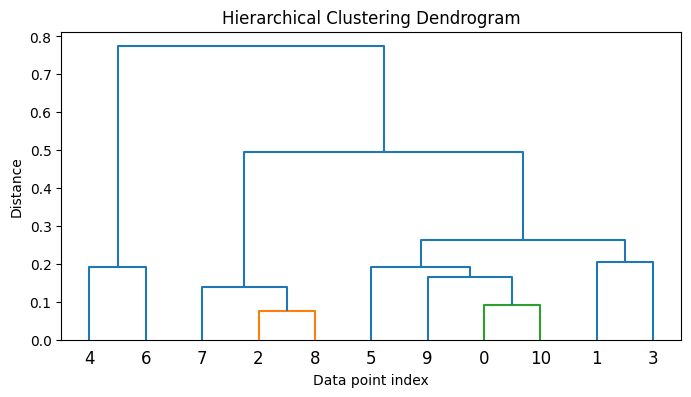

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


# Calculate the distance matrix
eta_smoothed = scipy.ndimage.gaussian_filter1d(eta, sigma=6, axis=1, radius=8)
distance_matrix = pdist(eta_smoothed, metric='correlation')

# Perform hierarchical/agglomerative clustering
Z = linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z, color_threshold=.12)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point index')
plt.ylabel('Distance')
plt.show()

In [179]:
eta[ordered].to_csv("F16_MULTI_ORDERED_ETA.csv")

In [187]:
denoised

AGRN  C1orf159  SDF4  B3GALT6  UBE2J2  ACAP3  INTS11  DVL1  AURKAIP1  \
0     0         0     0        0       0      0       0     0         0   
1     0         0     1        0       0      0       0     0         1   
2     1         1     1        1       1      1       1     1         2   
3     1         1     1        1       1      1       1     1         1   
4     1         1     1        1       1      1       1     1         1   
5     1         0     0        0       0      1       0     0         0   
6     1         1     1        1       1      1       1     1         1   
7     0         0     1        1       1      1       0     1         1   
8     0         0     1        0       0      0       0     1         1   
9     1         1     1        1       1      1       1     1         1   

   CCNL2  ...  MIRLET7BHG  PPARA  CDPF1  TTC38  GTSE1  TRMU  GRAMD4  CERK  \
0      0  ...           0      0      0      0      0     0       0     0   
1      1  ...           1      0      0      0      0     0       0     0   
2      1  ...           1      1      1      1      1     1       1     1   
3      1  ...           2      1      0      1      0     1       1     1   
4      1  ...           1      1      1      1      0     1       1     1   
5      1  ...           1      0      0      0      1     0       0     0   
6      1  ...           1      1      1      1      1     1       1     1   
7      0  ...           0      0      1      1      1     0       1     0   
8      0  ...           0      0      0      1      1     0       0     0   
9      1  ...           1      1      1      1      1     1       1     1   

   TBC1D22A  AL117329.1  
0         1           1  
1         1           2  
2         2           1  
3         1           2  
4         1           2  
5         1           2  
6         1           3  
7         0           1  
8         0           0  
9         1           1  

[10 rows x 8345 columns]